In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ga-customer-revenue-prediction

 50% 800M/1.56G [00:11<00:10, 76.0MB/s]
User cancelled operation


In [ ]:
!unzip /content/ga-customer-revenue-prediction.zip

Archive:  /content/ga-customer-revenue-prediction.zip
  inflating: sample_submission.csv   
  inflating: sample_submission_v2.csv  
  inflating: test.csv                
  inflating: test_v2.csv             
  inflating: train.csv               
  inflating: train_v2.csv            


In [ ]:
!rm test.csv
!rm train.csv
!rm /content/sample_submission.csv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import json
import pandas as pd
import random
import dask.dataframe as dd

# **Data Preprocessing**

In [ ]:
#reading only non json columns
columns=['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime']

In [ ]:
df=pd.read_csv('train_v2.csv',chunksize=50000,low_memory=False,usecols=columns)

In [ ]:
my_list=[]
for chunk in df:
  my_list.append(chunk)

In [ ]:
data_tr=pd.concat(my_list,axis=0)

In [ ]:
del my_list

In [ ]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   channelGrouping       object
 1   customDimensions      object
 2   date                  int64 
 3   fullVisitorId         object
 4   socialEngagementType  object
 5   visitId               int64 
 6   visitNumber           int64 
 7   visitStartTime        int64 
dtypes: int64(4), object(4)
memory usage: 104.3+ MB


In [ ]:
#now we will load other json columns using dask
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [ ]:
json_data=dd.read_csv('train_v2.csv',converters={column: json.loads for column in columns}, # loading the json columns properly
                     dtype={'fullVisitorId': 'str'})

In [ ]:
device_tr=pd.json_normalize(json_data['device'])

In [ ]:
device_tr.head()

,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory
0,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
1,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
3,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
4,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop


In [ ]:
totals_tr=pd.json_normalize(json_data['totals'])
totals_tr.shape

(1708337, 10)

In [ ]:
geo_tr=pd.json_normalize(json_data['geoNetwork'])
geo_tr.shape

(1708337, 11)

In [ ]:
traffic_tr=pd.json_normalize(json_data['trafficSource'])
traffic_tr.shape

(1708337, 14)

In [ ]:
final_tr=pd.concat([data_tr,geo_tr,traffic_tr,device_tr,totals_tr],axis=1)
final_tr.head()

,channelGrouping,customDimensions,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,continent,subContinent,...,visits,hits,pageviews,bounces,newVisits,sessionQualityDim,timeOnSite,transactions,transactionRevenue,totalTransactionRevenue
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Europe,Western Europe,...,1,1,1,1,1,1,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Americas,Northern America,...,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Americas,Northern America,...,1,2,2,NaN,1,1,38,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Asia,Western Asia,...,1,2,2,NaN,1,1,1,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Americas,Central America,...,1,2,2,NaN,1,1,52,NaN,NaN,NaN


In [ ]:
data_te=pd.read_csv('test_v2.csv',low_memory=False,converters={column: json.loads for column in columns})

In [ ]:
data_te.drop(columns='hits',inplace=True)

In [ ]:
geo_te=pd.json_normalize(data_te['geoNetwork'])
traffic_te=pd.json_normalize(data_te['trafficSource'])
totals_te=pd.json_normalize(data_te['totals'])
device_te=pd.json_normalize(data_te['device'])
print(geo_te.shape,traffic_te.shape,totals_te.shape,device_te.shape)

(401589, 11) (401589, 13) (401589, 10) (401589, 16)


In [ ]:
data_te.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",7460955084541987166,"{'continent': 'Asia', 'subContinent': 'Souther...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526099341,2,1526099341
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",460252456180441002,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526064483,166,1526064483
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",3461808543879602873,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526067157,2,1526067157
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",975129477712150630,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '4',...","{'referralPath': '(not set)', 'campaign': '(no...",1526107551,4,1526107551
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Internet Explorer', 'browserVersi...",8381672768065729990,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '4',...","{'referralPath': '(not set)', 'campaign': '(no...",1526060254,1,1526060254


In [ ]:
final_te=pd.concat([data_te,geo_te,traffic_te,device_te,totals_te],axis=1)
final_te.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,socialEngagementType,totals,trafficSource,visitId,...,visits,hits,pageviews,timeOnSite,sessionQualityDim,newVisits,transactions,transactionRevenue,totalTransactionRevenue,bounces
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",7460955084541987166,"{'continent': 'Asia', 'subContinent': 'Souther...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526099341,...,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",460252456180441002,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526064483,...,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",3461808543879602873,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '3',...","{'referralPath': '(not set)', 'campaign': '(no...",1526067157,...,1,4,3,24,1,NaN,NaN,NaN,NaN,NaN
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Chrome', 'browserVersion': 'not a...",975129477712150630,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '4',...","{'referralPath': '(not set)', 'campaign': '(no...",1526107551,...,1,5,4,25,1,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{'browser': 'Internet Explorer', 'browserVersi...",8381672768065729990,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '4',...","{'referralPath': '(not set)', 'campaign': '(no...",1526060254,...,1,5,4,49,1,1,NaN,NaN,NaN,NaN


In [ ]:
final_te.drop(columns=columns,inplace=True)

In [ ]:
#deleting columns that are in not in train but are in test and vice versa
cols_to_del=set(final_tr.columns)-set(final_te.columns)
print(cols_to_del)

{'campaignCode'}


In [ ]:
final_tr.drop(columns=cols_to_del,inplace=True)
print(final_tr.shape,
final_te.shape)

(1708337, 58) (401589, 58)


In [ ]:
print(final_tr.columns)
print(final_te.columns)

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'continent', 'subContinent', 'country', 'region', 'metro', 'city',
       'cityId', 'networkDomain', 'latitude', 'longitude', 'networkLocation',
       'campaign', 'source', 'medium', 'keyword',
       'adwordsClickInfo.criteriaParameters', 'referralPath', 'isTrueDirect',
       'adContent', 'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType',
       'adwordsClickInfo.isVideoAd', 'browser', 'browserVersion',
       'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile',
       'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion',
       'language', 'screenColors', 'screenResolution', 'deviceCategory',
       'visits', 'hits', 'pageviews', 'bounces', 'newVisits',
       'se

In [ ]:
#rearranging the columns in test dataframe according to train dataframe
final_te=final_te[final_tr.columns]
print(final_tr.columns)
print(final_te.columns)       

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'continent', 'subContinent', 'country', 'region', 'metro', 'city',
       'cityId', 'networkDomain', 'latitude', 'longitude', 'networkLocation',
       'campaign', 'source', 'medium', 'keyword',
       'adwordsClickInfo.criteriaParameters', 'referralPath', 'isTrueDirect',
       'adContent', 'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType',
       'adwordsClickInfo.isVideoAd', 'browser', 'browserVersion',
       'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile',
       'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion',
       'language', 'screenColors', 'screenResolution', 'deviceCategory',
       'visits', 'hits', 'pageviews', 'bounces', 'newVisits',
       'se

In [ ]:
final_te.shape

(401589, 58)

In [ ]:
final_tr.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_train',index=False)

In [ ]:
final_te.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_test',index=False)

In [ ]:
data_tr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_train',low_memory=False)
data_te=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_test',low_memory=False)

In [ ]:
#deleting totalTransactionRevenue column as it is duplicate of transactionRevenue
data_tr.drop(columns='totalTransactionRevenue',inplace=True)
data_te.drop(columns='totalTransactionRevenue',inplace=True)

In [ ]:
data_tr['transactionRevenue']=data_tr['transactionRevenue'].fillna(0)
data_te['transactionRevenue']=data_te['transactionRevenue'].fillna(0)
data_tr['transactions']=data_tr['transactions'].fillna(0)
data_te['transactions']=data_te['transactions'].fillna(0)

In [ ]:
#function to check missing values amount in a feature
def missing_prcnt(data):
  missing=data.isnull().sum()
  percentage=(missing/len(data))*100
  return percentage

In [ ]:
columns=data_tr.columns
missing_columns=[]
cols_to_del=[]
for i in columns:
  value=missing_prcnt(data_tr[i])
  print('Percentage of values missing in '+str(i)+" : "+str(value)+' %')
  if value>0:
    missing_columns.append(i)
  if value>70:
    cols_to_del.append(i)  

Percentage of values missing in channelGrouping : 0.0 %
Percentage of values missing in customDimensions : 0.0 %
Percentage of values missing in date : 0.0 %
Percentage of values missing in fullVisitorId : 0.0 %
Percentage of values missing in socialEngagementType : 0.0 %
Percentage of values missing in visitId : 0.0 %
Percentage of values missing in visitNumber : 0.0 %
Percentage of values missing in visitStartTime : 0.0 %
Percentage of values missing in continent : 0.0 %
Percentage of values missing in subContinent : 0.0 %
Percentage of values missing in country : 0.0 %
Percentage of values missing in region : 0.0 %
Percentage of values missing in metro : 0.0 %
Percentage of values missing in city : 0.0 %
Percentage of values missing in cityId : 0.0 %
Percentage of values missing in networkDomain : 0.0 %
Percentage of values missing in latitude : 0.0 %
Percentage of values missing in longitude : 0.0 %
Percentage of values missing in networkLocation : 0.0 %
Percentage of values missin

We are removing the feaures where missing percentage is more than 70% .
So such features are :

But we will store the missing record information using new features that will contain 1 if the corresponding value of any of the above features is nan else 0

In [ ]:
print('Columns that have missing rows :',missing_columns)
print('Columns that have more than 60% missing data',cols_to_del)

Columns that have missing rows : ['keyword', 'referralPath', 'isTrueDirect', 'adContent', 'adwordsClickInfo.page', 'adwordsClickInfo.slot', 'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd', 'pageviews', 'bounces', 'newVisits', 'sessionQualityDim', 'timeOnSite']
Columns that have more than 60% missing data ['adContent', 'adwordsClickInfo.page', 'adwordsClickInfo.slot', 'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd']


In [ ]:
#deleting the columns from the datasets
data_tr.drop(columns=cols_to_del,inplace=True)
data_te.drop(columns=cols_to_del,inplace=True)
print(data_tr.shape,data_te.shape)

(1708337, 51) (401589, 51)


In [ ]:
#checking and deleting constant features that contain single value thoughout all rows
const=[]
for i in data_tr.columns:
  print('Number of unqiue values in '+str(i)+' :',data_tr[i].nunique())
  if data_tr[i].nunique()==1:
    const.append(i)

Number of unqiue values in channelGrouping : 8
Number of unqiue values in customDimensions : 6
Number of unqiue values in date : 638
Number of unqiue values in fullVisitorId : 1331778
Number of unqiue values in socialEngagementType : 1
Number of unqiue values in visitId : 1665802
Number of unqiue values in visitNumber : 457
Number of unqiue values in visitStartTime : 1667423
Number of unqiue values in continent : 6
Number of unqiue values in subContinent : 23
Number of unqiue values in country : 228
Number of unqiue values in region : 483
Number of unqiue values in metro : 123
Number of unqiue values in city : 956
Number of unqiue values in cityId : 1
Number of unqiue values in networkDomain : 41982
Number of unqiue values in latitude : 1
Number of unqiue values in longitude : 1
Number of unqiue values in networkLocation : 1
Number of unqiue values in campaign : 33
Number of unqiue values in source : 345
Number of unqiue values in medium : 7
Number of unqiue values in keyword : 4546
Nu

In [ ]:
print('Constant features :',const)

Constant features : ['socialEngagementType', 'cityId', 'latitude', 'longitude', 'networkLocation', 'adwordsClickInfo.criteriaParameters', 'isTrueDirect', 'browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'visits', 'bounces', 'newVisits']


In [ ]:
data_tr.drop(columns=const,inplace=True)
data_te.drop(columns=const,inplace=True)
print(data_tr.shape,data_te.shape)

(1708337, 29) (401589, 29)


In [ ]:
#now we will fill remaining colunns that are missing
missing_columns=list(set(missing_columns)-set(cols_to_del)-set(const))
missing_columns

['sessionQualityDim', 'timeOnSite', 'pageviews', 'keyword', 'referralPath']

In [ ]:
#sessionQualityDim is a categorical column as it can take value from range 1-100 so we will fill its value using its mode
#timeOnSite and pageviews are numerical column so we will fill them with median value

In [ ]:
data_tr['sessionQualityDim']=data_tr['sessionQualityDim'].fillna(0)
data_te['sessionQualityDim']=data_te['sessionQualityDim'].fillna(0)

data_tr['timeOnSite']=data_tr['timeOnSite'].fillna(0)
data_te['timeOnSite']=data_te['timeOnSite'].fillna(0)

data_tr['pageviews']=data_tr['pageviews'].fillna(0)
data_te['pageviews']=data_te['pageviews'].fillna(0)

data_tr['keyword']=data_tr['keyword'].fillna(data_tr['keyword'].mode()[0])
data_te['keyword']=data_te['keyword'].fillna(data_tr['keyword'].mode()[0])

data_tr['referralPath']=data_tr['referralPath'].fillna(data_tr['referralPath'].mode()[0])
data_te['referralPath']=data_te['referralPath'].fillna(data_tr['referralPath'].mode()[0])

In [ ]:
columns=data_tr.columns
for i in columns:
  value=missing_prcnt(data_tr[i])
  print('Percentage of values missing in '+str(i)+" : "+str(value)+' %')

Percentage of values missing in channelGrouping : 0.0 %
Percentage of values missing in customDimensions : 0.0 %
Percentage of values missing in date : 0.0 %
Percentage of values missing in fullVisitorId : 0.0 %
Percentage of values missing in visitId : 0.0 %
Percentage of values missing in visitNumber : 0.0 %
Percentage of values missing in visitStartTime : 0.0 %
Percentage of values missing in continent : 0.0 %
Percentage of values missing in subContinent : 0.0 %
Percentage of values missing in country : 0.0 %
Percentage of values missing in region : 0.0 %
Percentage of values missing in metro : 0.0 %
Percentage of values missing in city : 0.0 %
Percentage of values missing in networkDomain : 0.0 %
Percentage of values missing in campaign : 0.0 %
Percentage of values missing in source : 0.0 %
Percentage of values missing in medium : 0.0 %
Percentage of values missing in keyword : 0.0 %
Percentage of values missing in referralPath : 0.0 %
Percentage of values missing in browser : 0.0 

In [ ]:
columns=data_tr.columns
cols_to_del=[]
for i in columns:
  value=missing_prcnt(data_te[i])
  print('Percentage of values missing in '+str(i)+" : "+str(value)+' %')

Percentage of values missing in channelGrouping : 0.0 %
Percentage of values missing in customDimensions : 0.0 %
Percentage of values missing in date : 0.0 %
Percentage of values missing in fullVisitorId : 0.0 %
Percentage of values missing in visitId : 0.0 %
Percentage of values missing in visitNumber : 0.0 %
Percentage of values missing in visitStartTime : 0.0 %
Percentage of values missing in continent : 0.0 %
Percentage of values missing in subContinent : 0.0 %
Percentage of values missing in country : 0.0 %
Percentage of values missing in region : 0.0 %
Percentage of values missing in metro : 0.0 %
Percentage of values missing in city : 0.0 %
Percentage of values missing in networkDomain : 0.0 %
Percentage of values missing in campaign : 0.0 %
Percentage of values missing in source : 0.0 %
Percentage of values missing in medium : 0.0 %
Percentage of values missing in keyword : 0.0 %
Percentage of values missing in referralPath : 0.0 %
Percentage of values missing in browser : 0.0 

In [ ]:
columns=data_tr.columns
columns_to_be_del=[]
for i in columns:
  if len(data_tr[i].unique())!=len(data_tr):
    print('\nNumber of unique values in '+str(i)+' : '+str(len(data_tr[i].unique())))
    print('Unique Values : '+str(data_tr[i].unique()))
    print('*-----------------------------------------------------------------------------------------------------------------------------------------*')
  if len(data_tr[i].unique())==(1 or len(data_tr)) :
    columns_to_be_del.append(i)


Number of unique values in channelGrouping : 8
Unique Values : ['Organic Search' 'Referral' 'Direct' 'Paid Search' 'Display' 'Affiliates'
 'Social' '(Other)']
*-----------------------------------------------------------------------------------------------------------------------------------------*

Number of unique values in customDimensions : 6
Unique Values : ["[{'index': '4', 'value': 'EMEA'}]"
 "[{'index': '4', 'value': 'North America'}]"
 "[{'index': '4', 'value': 'Central America'}]" '[]'
 "[{'index': '4', 'value': 'APAC'}]"
 "[{'index': '4', 'value': 'South America'}]"]
*-----------------------------------------------------------------------------------------------------------------------------------------*

Number of unique values in date : 638
Unique Values : [20171016 20160902 20171130 20170126 20170623 20170312 20170203 20180415
 20171110 20160811 20170613 20170113 20171111 20161118 20161110 20161112
 20170621 20180117 20180103 20161123 20180120 20180307 20180429 20170501
 

In [ ]:
#dropping visitId column as it is not useful for our task
data_tr.drop(columns='visitId',inplace=True)
data_te.drop(columns='visitId',inplace=True)
print(data_tr.shape,data_te.shape)

(1708337, 28) (401589, 28)


In [ ]:
data_tr['date'].head()

0    20171016
1    20171016
2    20171016
3    20171016
4    20171016
Name: date, dtype: int64

In [ ]:
data_tr['date']=data_tr['date'].astype(str).apply(lambda x: str(x[0:4])+'-'+str(x[4:6]+'-'+str(x[6:8])))
data_te['date']=data_te['date'].astype(str).apply(lambda x: str(x[0:4])+'-'+str(x[4:6]+'-'+str(x[6:8])))

In [ ]:
data_tr['date'].head()

0    2017-10-16
1    2017-10-16
2    2017-10-16
3    2017-10-16
4    2017-10-16
Name: date, dtype: object

In [ ]:
#saving encoded data
data_tr.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/unencoded_tr.csv',index=False)
data_te.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/unencoded_te.csv',index=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_tr.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'visitNumber', 'visitStartTime', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'campaign', 'source',
       'medium', 'keyword', 'referralPath', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'hits', 'pageviews', 'sessionQualityDim',
       'timeOnSite', 'transactions', 'transactionRevenue'],
      dtype='object')

In [ ]:
categorical=['channelGrouping', 'customDimensions', 'continent', 'subContinent',
       'country', 'region', 'metro', 'city', 'networkDomain', 'campaign',
       'source', 'medium', 'keyword', 'referralPath', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory']
for i in categorical:
  enc=LabelEncoder()
  enc.fit(list(set(data_tr[i].unique()).union(set(data_te[i].unique())))) 
  data_tr[i]=enc.transform(data_tr[i])
  data_te[i]=enc.transform(data_te[i])     

In [ ]:
#saving encoded data
data_tr.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/encoded_tr.csv',index=False)
data_te.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/encoded_te.csv',index=False)

# **EDA :**

In [ ]:
#saving encoded data
data_tr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/unencoded_tr.csv',low_memory=False)
data_te=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/unencoded_te.csv',low_memory=False)

In [ ]:
print(data_tr.shape)
print(data_te.shape)

(1708337, 28)
(401589, 28)


In [ ]:
data_tr.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'visitNumber', 'visitStartTime', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'campaign', 'source',
       'medium', 'keyword', 'referralPath', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'hits', 'pageviews', 'sessionQualityDim',
       'timeOnSite', 'transactions', 'transactionRevenue'],
      dtype='object')

lets first visualize our target variable.

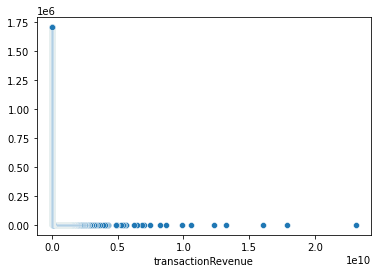

In [ ]:
sn.scatterplot(y=list(range(len(data_tr))),x=data_tr['transactionRevenue'].sort_values(ascending=False))
plt.show()

In [ ]:
print('Number of rows having non zero transactions in train dataset =',len(data_tr.loc[data_tr['transactionRevenue']!=0]))
print('Number of rows having non zero transactions in test dataset =',len(data_te.loc[data_te['transactionRevenue']!=0]))

Number of rows having non zero transactions in train dataset = 18514
Number of rows having non zero transactions in test dataset = 4594


We can see our target variable follows pareto distribution. let us also check the log of this plot.

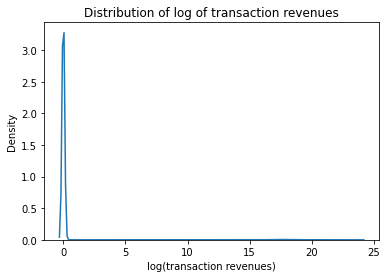

In [ ]:
sn.kdeplot(np.log1p(data_tr['transactionRevenue'].values))
plt.xlabel('log(transaction revenues)')
plt.title('Distribution of log of transaction revenues')
plt.show()

We can see that even after taking the log of transaction revenue it is still skewed

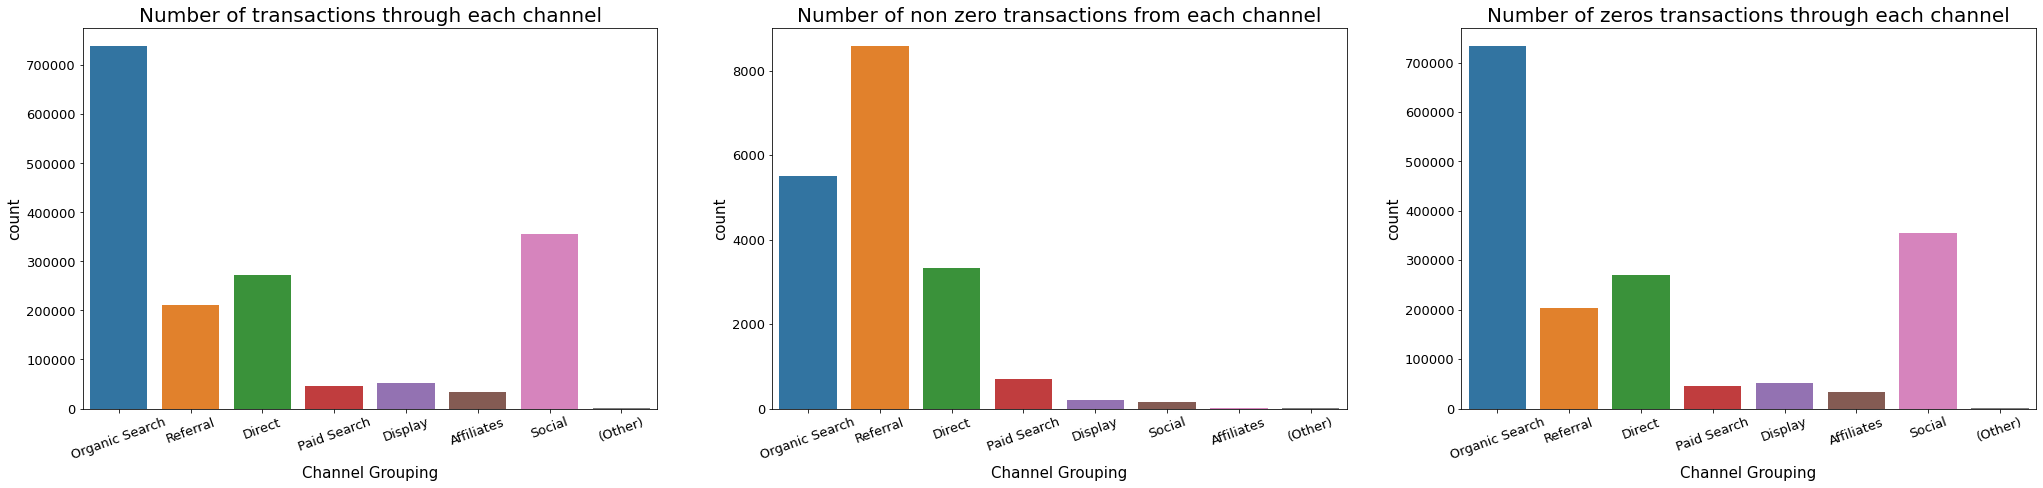

In [ ]:
plt.figure(figsize=(35,7))
plt.subplot(131)
sn.countplot(x=data_tr['channelGrouping'])
plt.title('Number of transactions through each channel',fontdict={'fontsize':20})
plt.xticks(fontsize=13,rotation=20)
plt.yticks(fontsize=13)
plt.ylabel('count',fontdict={'fontsize':15})
plt.xlabel('Channel Grouping',fontdict={'fontsize':15})
plt.subplot(132)
sn.countplot(x=data_tr['channelGrouping'].loc[data_tr['transactionRevenue']!=0])
plt.title('Number of non zero transactions from each channel',fontdict={'fontsize':20})
plt.xticks(fontsize=13,rotation=20)
plt.yticks(fontsize=13)
plt.ylabel('count',fontdict={'fontsize':15})
plt.xlabel('Channel Grouping',fontdict={'fontsize':15})
plt.subplot(133)
sn.countplot(x=data_tr['channelGrouping'].loc[data_tr['transactionRevenue']==0])
plt.title('Number of zeros transactions through each channel',fontdict={'fontsize':20})
plt.xticks(fontsize=13,rotation=20)
plt.yticks(fontsize=13)
plt.ylabel('count',fontdict={'fontsize':15})
plt.xlabel('Channel Grouping',fontdict={'fontsize':15})
plt.show()

**Observations-**
1. From the above plots we can see that there are very high number of users coming through organic search, direct and social channel.
2. There are not much users coming through Referral channel but it has the highest number of non zero transactions.
3. Marketing team should focus more on referral programs to gain more revenue.

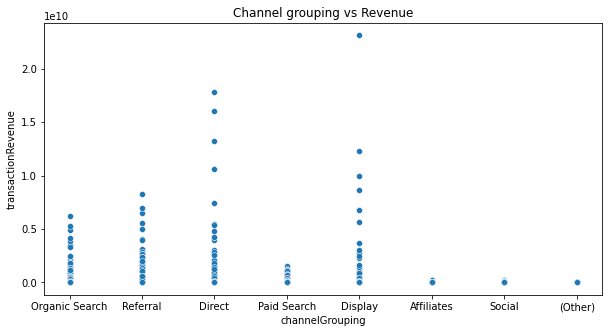

In [ ]:
plt.figure(figsize=(10,5))
sn.scatterplot(x=data_tr['channelGrouping'],y=data_tr['transactionRevenue'])
plt.title('Channel grouping vs Revenue')
plt.show()

In [ ]:
#function to get the average revenue collected per unique value in the feature
def avg_rev(column_name,data):
  values=data[column_name].unique()
  avg_val=dict()
  for i in values:
    sum=data.groupby(data[column_name]).sum()['transactionRevenue'][i]
    num=data.groupby(data[column_name])[column_name].count()[i]
    avg_val[i]=sum/num
  return avg_val  

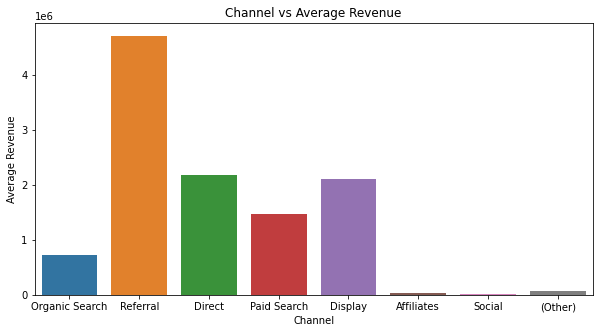

In [ ]:
avg_val=avg_rev('channelGrouping',data_tr)
plt.figure(figsize=(10,5))
keys=list(avg_val.keys())
values=[avg_val.get(i) for i in keys]
sn.barplot(x=keys,y=values)
plt.xlabel('Channel')
plt.ylabel('Average Revenue')
plt.title('Channel vs Average Revenue')
plt.show()

We can see, users from refferal, direct, display group generating the highest amount of average revenue.

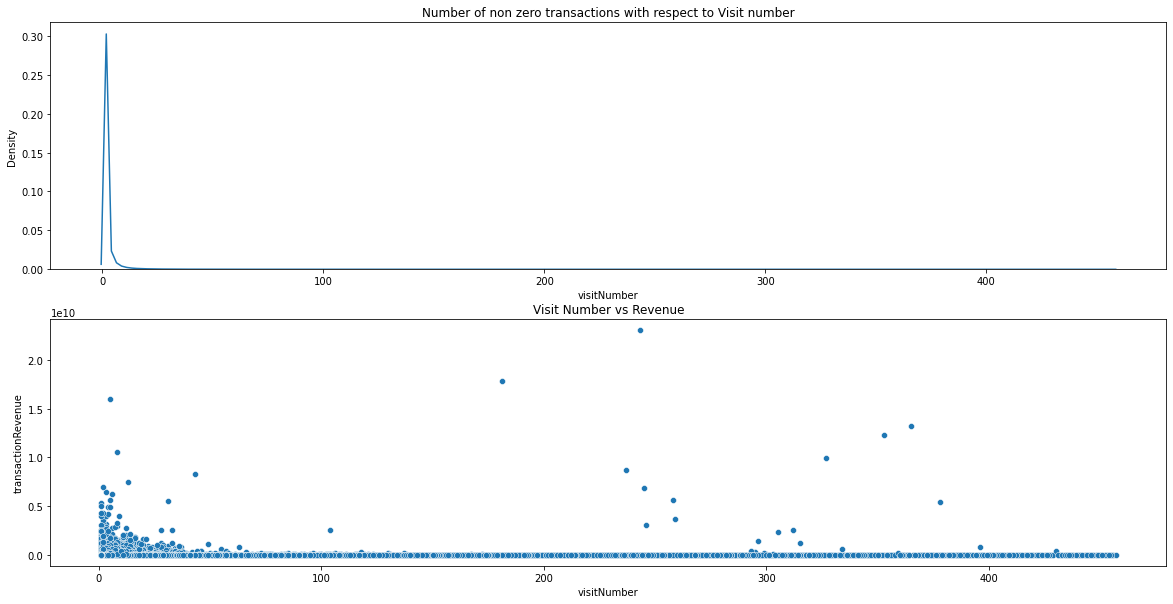

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(211)
sn.kdeplot(x=data_tr['visitNumber'])
plt.title('Number of non zero transactions with respect to Visit number')
plt.subplot(212)
sn.scatterplot(x=data_tr['visitNumber'],y=data_tr['transactionRevenue'])
plt.title('Visit Number vs Revenue')
plt.show()

**Observation :**
1. From the above plot we can see, new visitors are more and only few users visiting store multiple times.
2. The above plot looks like a pareto distribution.
3. Mostly users visiting first time or few number of times, they are more likely to generate revenue.

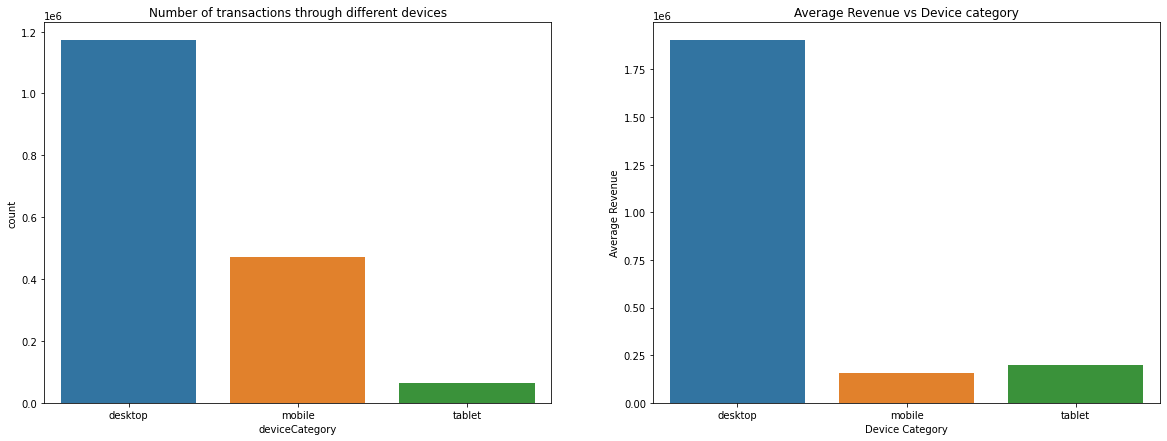

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(121)
sn.countplot(x=data_tr['deviceCategory'])
plt.title('Number of transactions through different devices')
plt.subplot(122)
avg_val=avg_rev('deviceCategory',data_tr)
keys=list(avg_val.keys())
values=[avg_val.get(i) for i in keys]
sn.barplot(x=keys,y=values)
plt.xlabel('Device Category')
plt.ylabel('Average Revenue')
plt.title('Average Revenue vs Device category')
plt.show()

**Observations :**
1. Mostly users are using desktop and mobile phones for visiting store.
2. Average revenue through mobile device users is the lowest and highest in desktop users. 

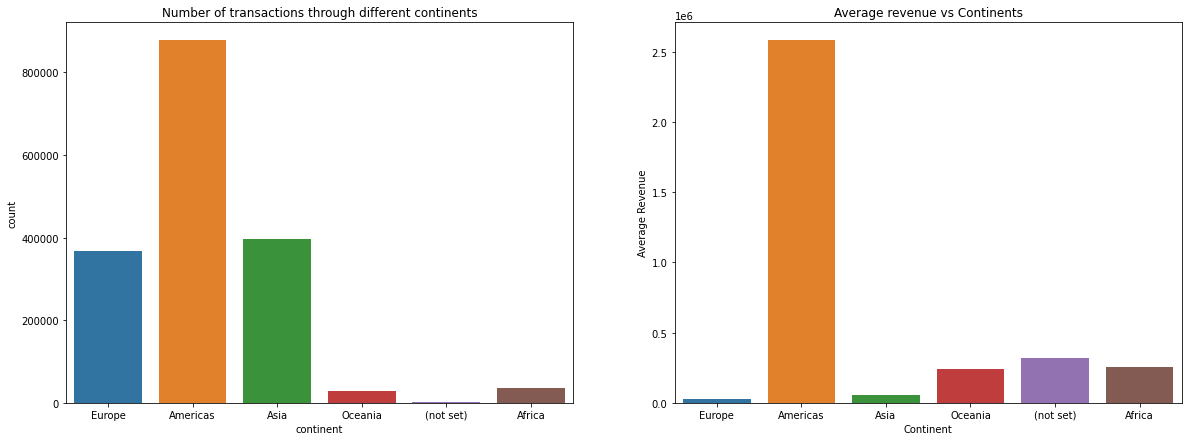

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(121)
sn.countplot(x=data_tr['continent'])
plt.title('Number of transactions through different continents')
plt.subplot(122)
avg_val=avg_rev('continent',data_tr)
keys=list(avg_val.keys())
values=[avg_val.get(i) for i in keys]
sn.barplot(x=keys,y=values)
plt.xlabel('Continent')
plt.ylabel('Average Revenue')
plt.title('Average revenue vs Continents')
plt.show()

**Observations :**
1. Mostly users from Europe, America and Asia are visiting the store.
2. Highest average revenue is generated by Americas.

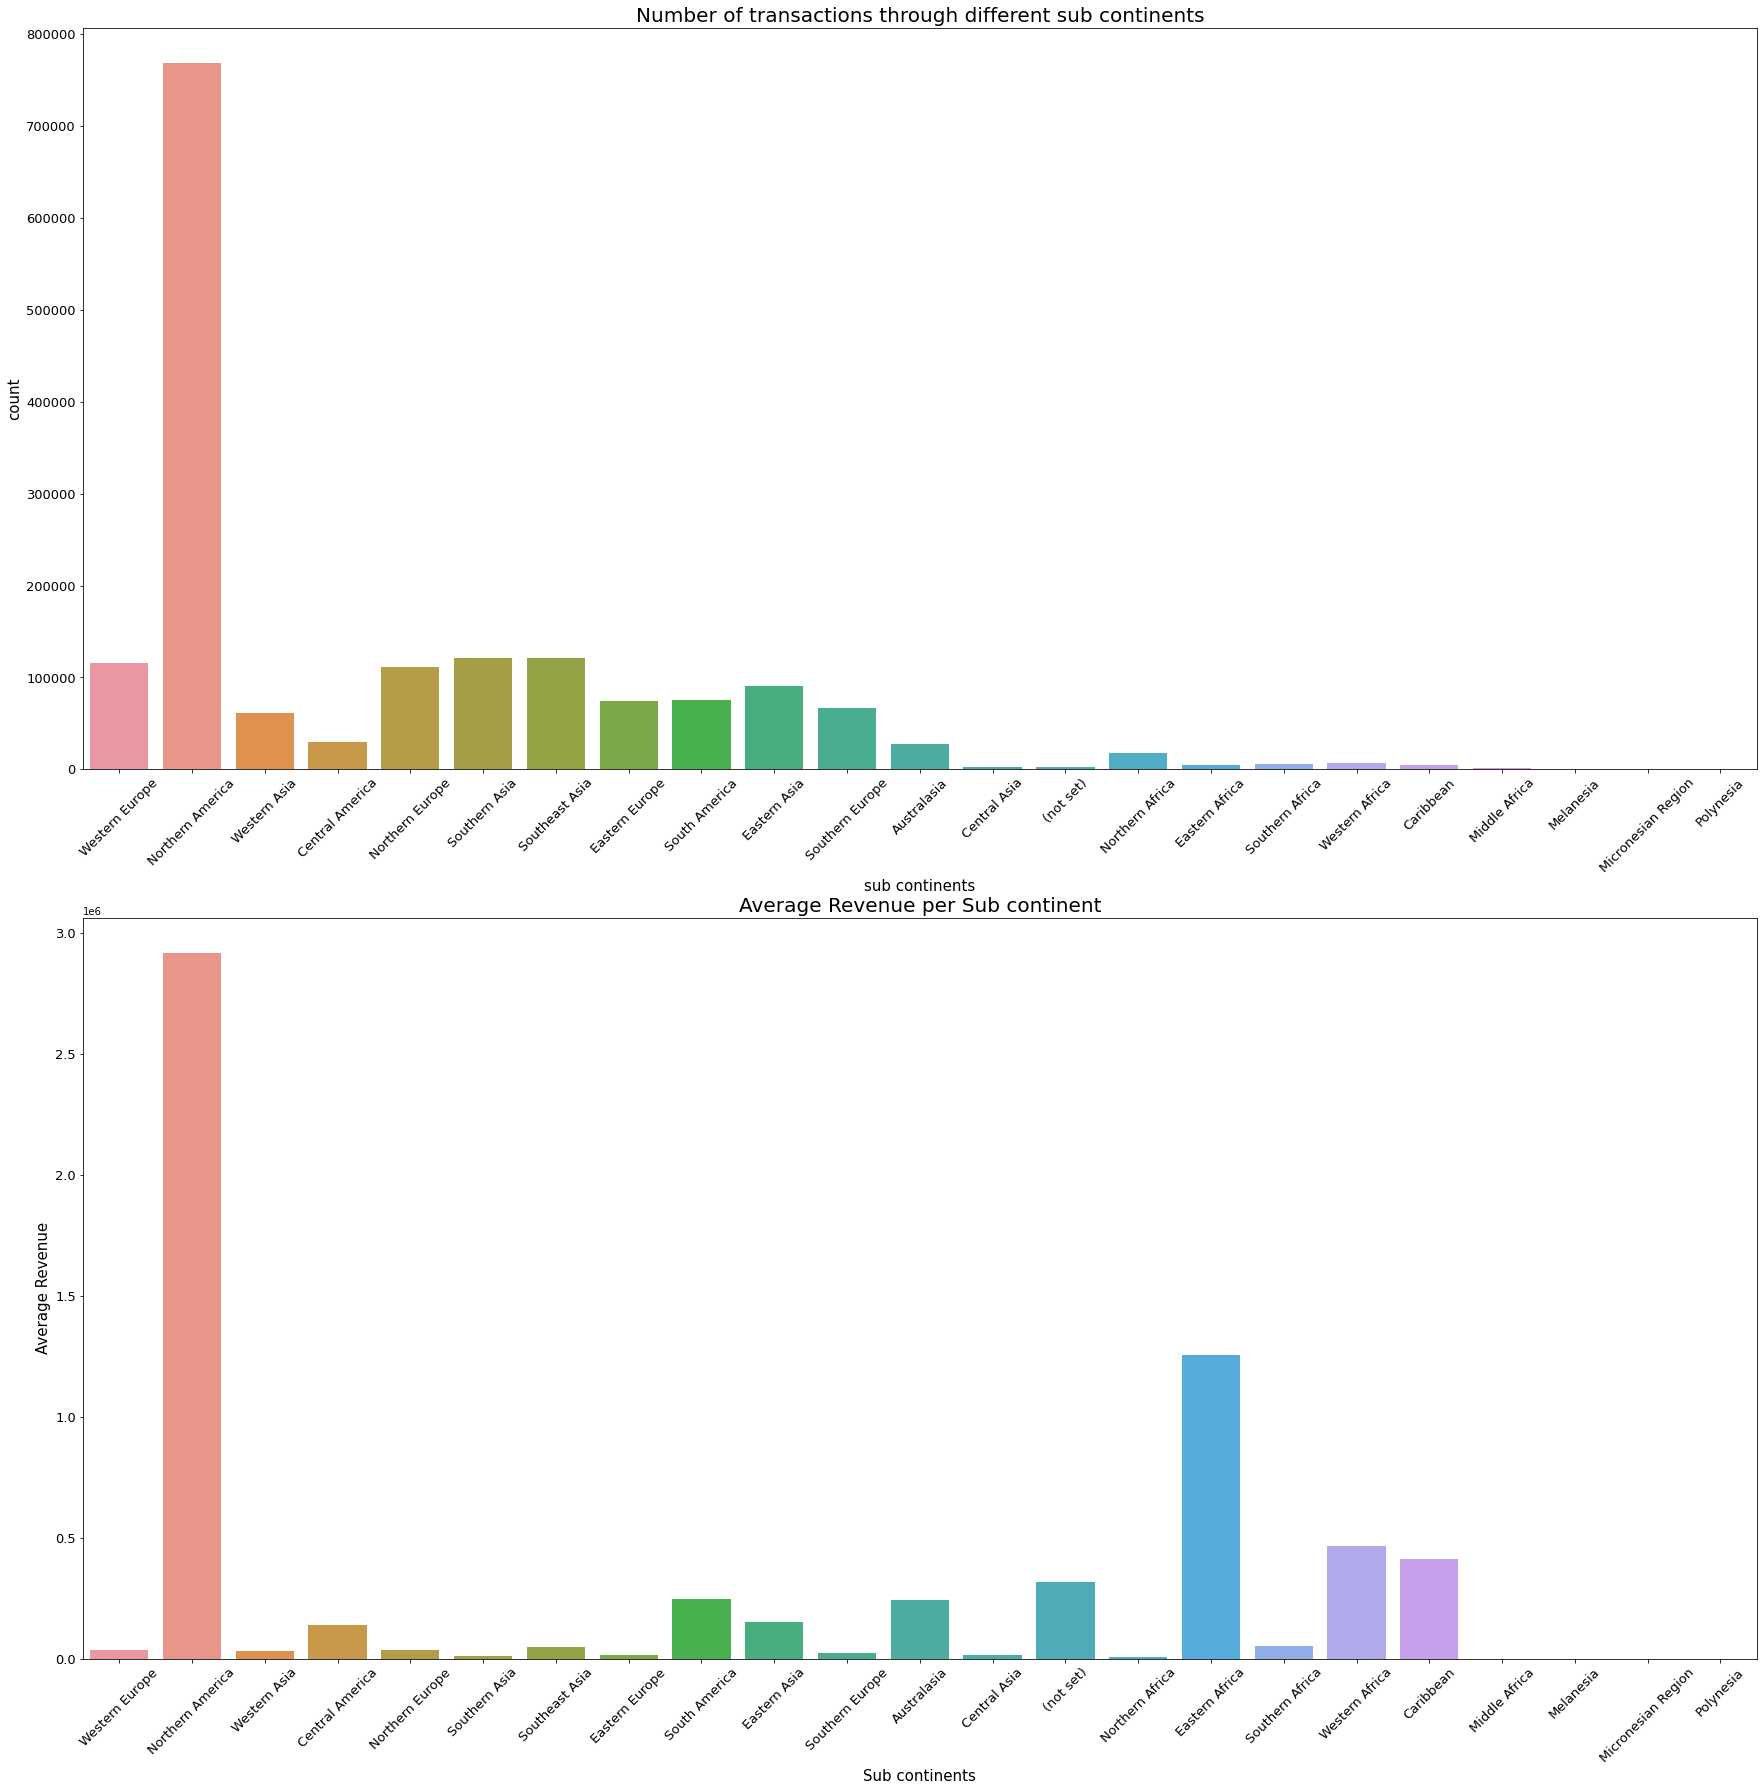

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(211)
sn.countplot(x=data_tr['subContinent'])
plt.title('Number of transactions through different sub continents',fontdict={'fontsize':20})
plt.xticks(fontsize=13,rotation=45)
plt.yticks(fontsize=13)
plt.ylabel('count',fontdict={'fontsize':15})
plt.xlabel('sub continents',fontdict={'fontsize':15})
plt.subplot(212)
avg_val=avg_rev('subContinent',data_tr)
keys=list(avg_val.keys())
values=[avg_val.get(i) for i in keys]
sn.barplot(x=keys,y=values)
plt.title('Average Revenue per Sub continent',fontdict={'fontsize':20})
plt.xticks(fontsize=13,rotation=45)
plt.yticks(fontsize=13)
plt.ylabel('Average Revenue',fontdict={'fontsize':15})
plt.xlabel('Sub continents',fontdict={'fontsize':15})
plt.show()

**Observations :**
1. From the above plots we can see the highest number of transacions are coming from North America and some small amount of transactions through other sub continents.
2. North America serves the highest average revenue, and sub continents like South America, Northern Europe, Eastern Asia, Caribbean, Central America has noticable average revenue where rest are negligible.

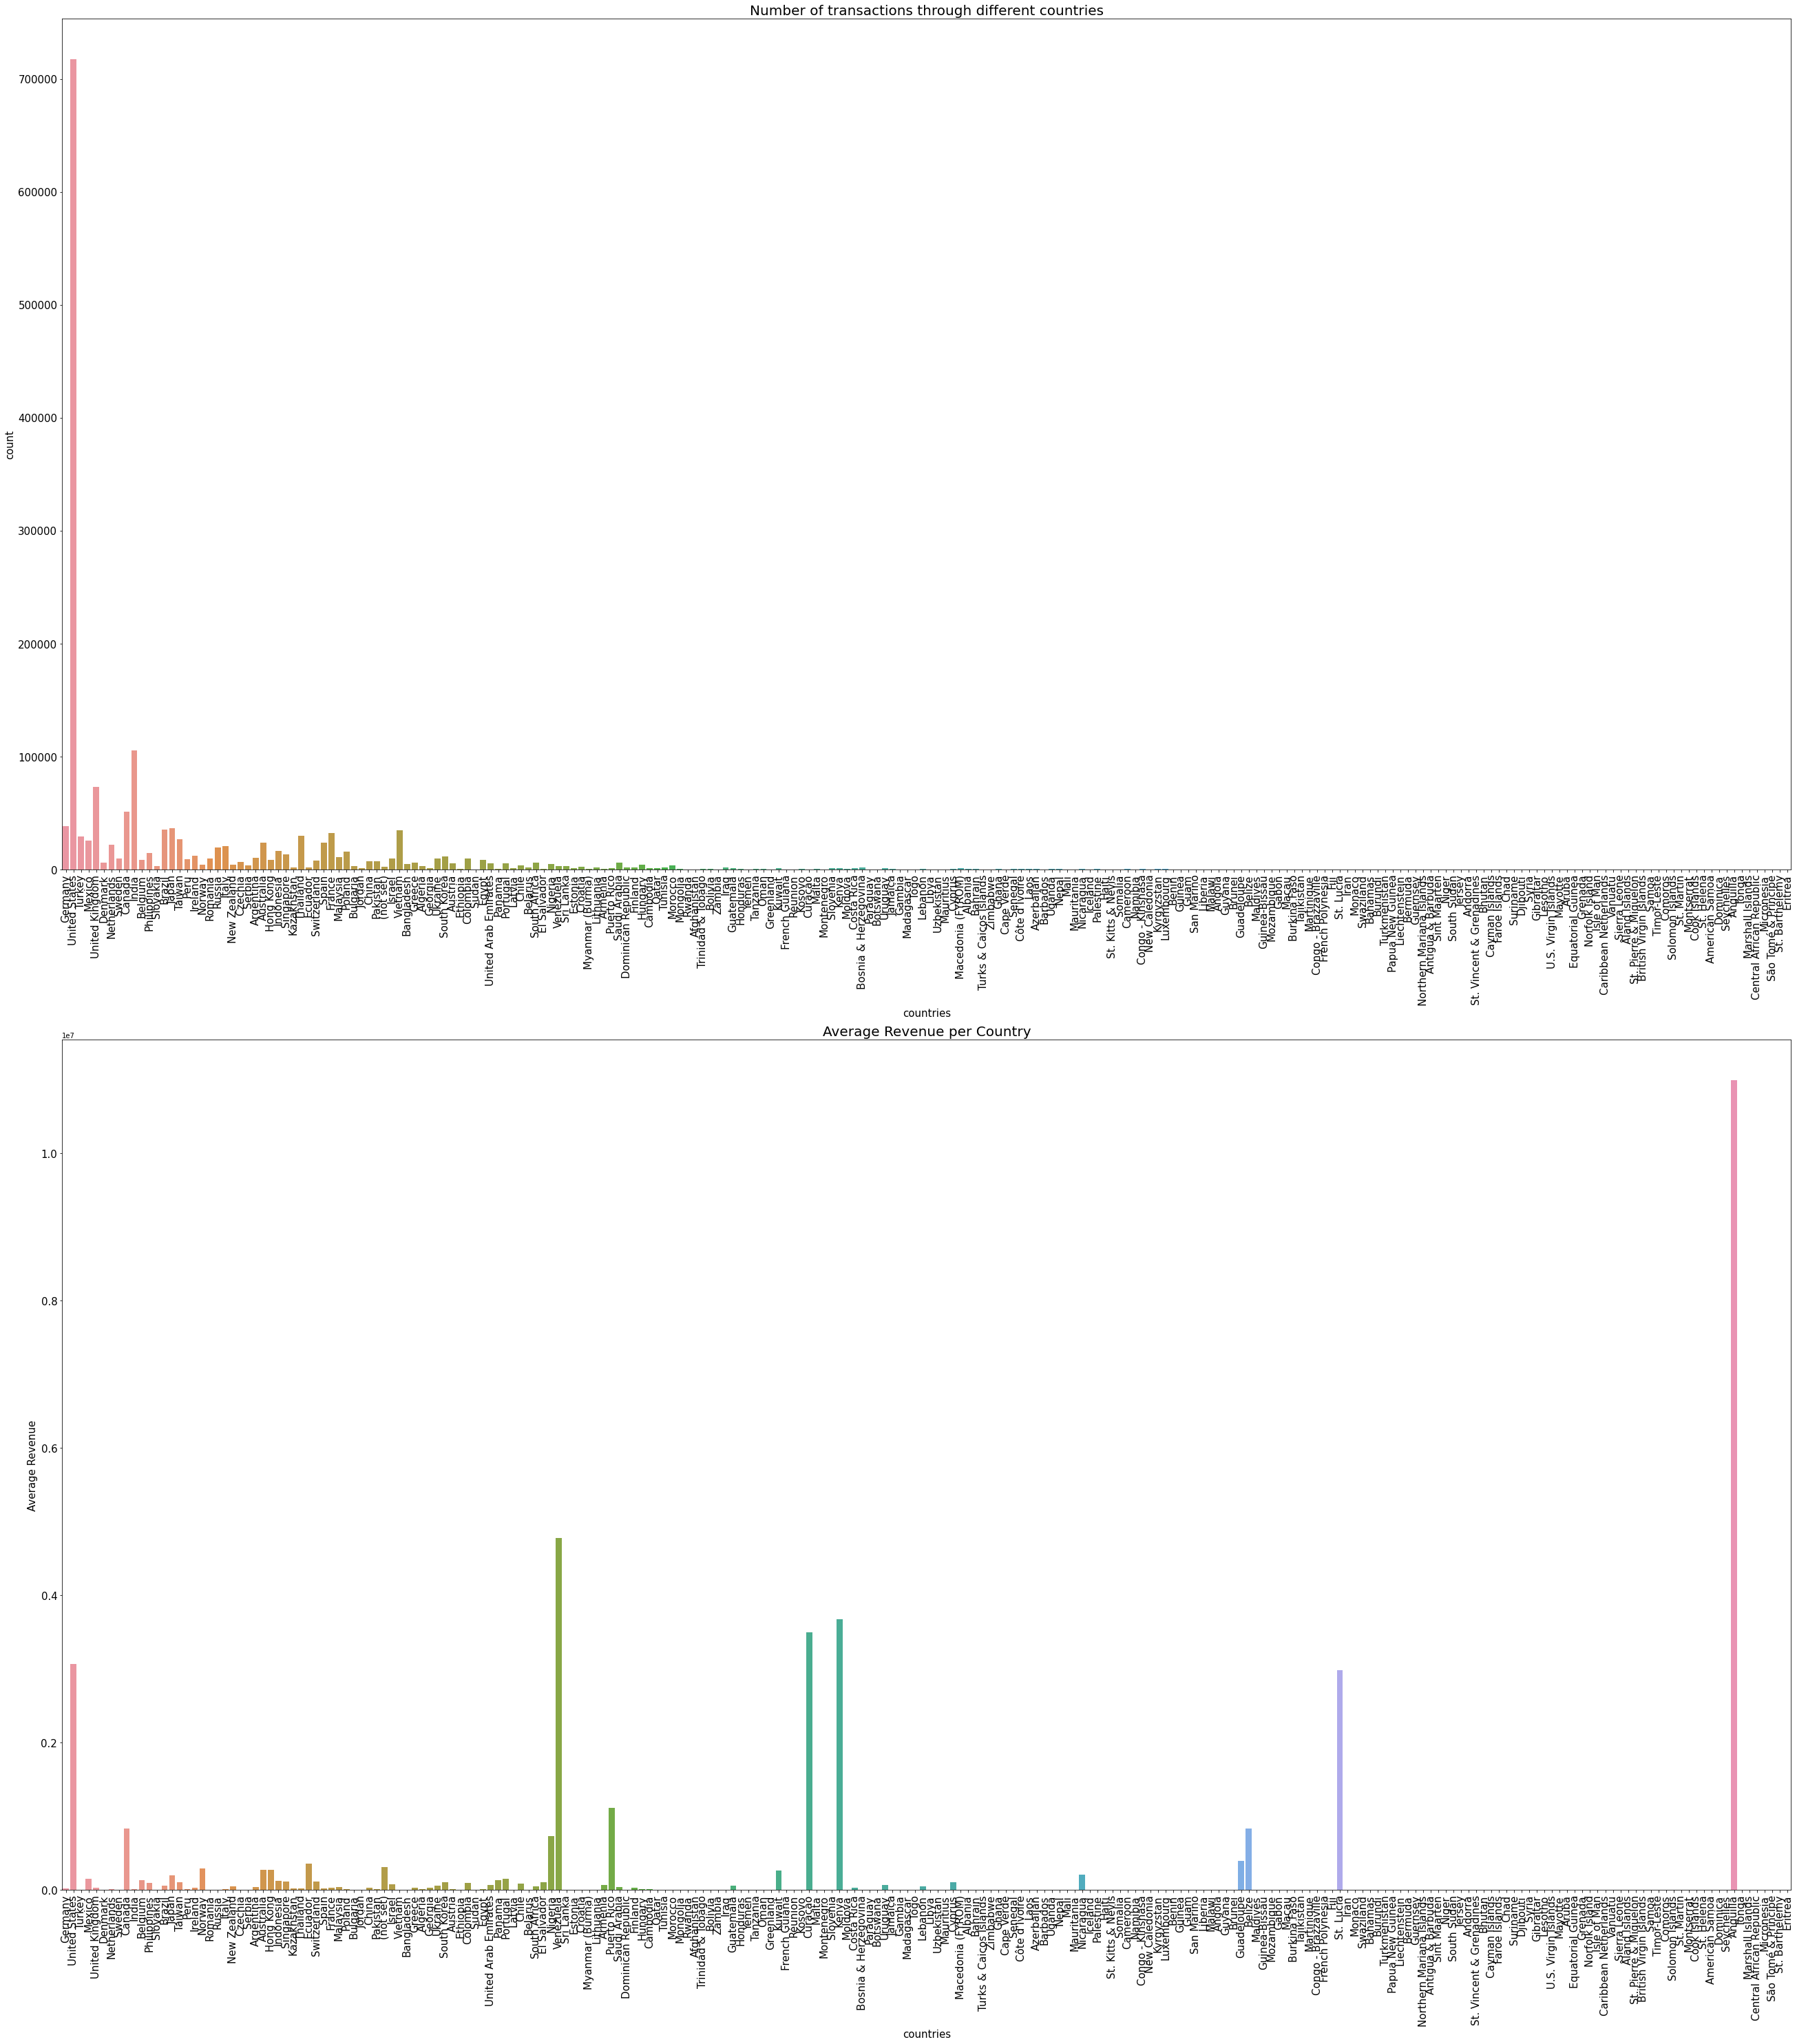

In [ ]:
plt.figure(figsize=(45,50))
plt.subplot(211)
sn.countplot(x=data_tr['country'])
plt.title('Number of transactions through different countries',fontdict={'fontsize':20})
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
plt.ylabel('count',fontdict={'fontsize':15})
plt.xlabel('countries',fontdict={'fontsize':15})
plt.subplot(212)
avg_val=avg_rev('country',data_tr)
keys=list(avg_val.keys())
values=[avg_val.get(i) for i in keys]
sn.barplot(x=keys,y=values)
plt.title('Average Revenue per Country',fontdict={'fontsize':20})
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
plt.ylabel('Average Revenue',fontdict={'fontsize':15})
plt.xlabel('countries',fontdict={'fontsize':15})
plt.show()

In [ ]:
data_tr.groupby(['country'])['country'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(5)

,country,count
218,United States,717217
93,India,105317
217,United Kingdom,73341
36,Canada,51057
75,Germany,38516


**Observations :**
1. From the above plots we can see there are users from many different countries visiting the store but top 5 are United States, India, United Kingdom, Canada, Germany.
2. Interestingly the country named Anguilla have the highest average revenue which is even greater than United States.
3. Some other noticeable average revenues are from United States, Canada, Hong Kong, Venezuela, Kuwait, Panama, Puerto Rico.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

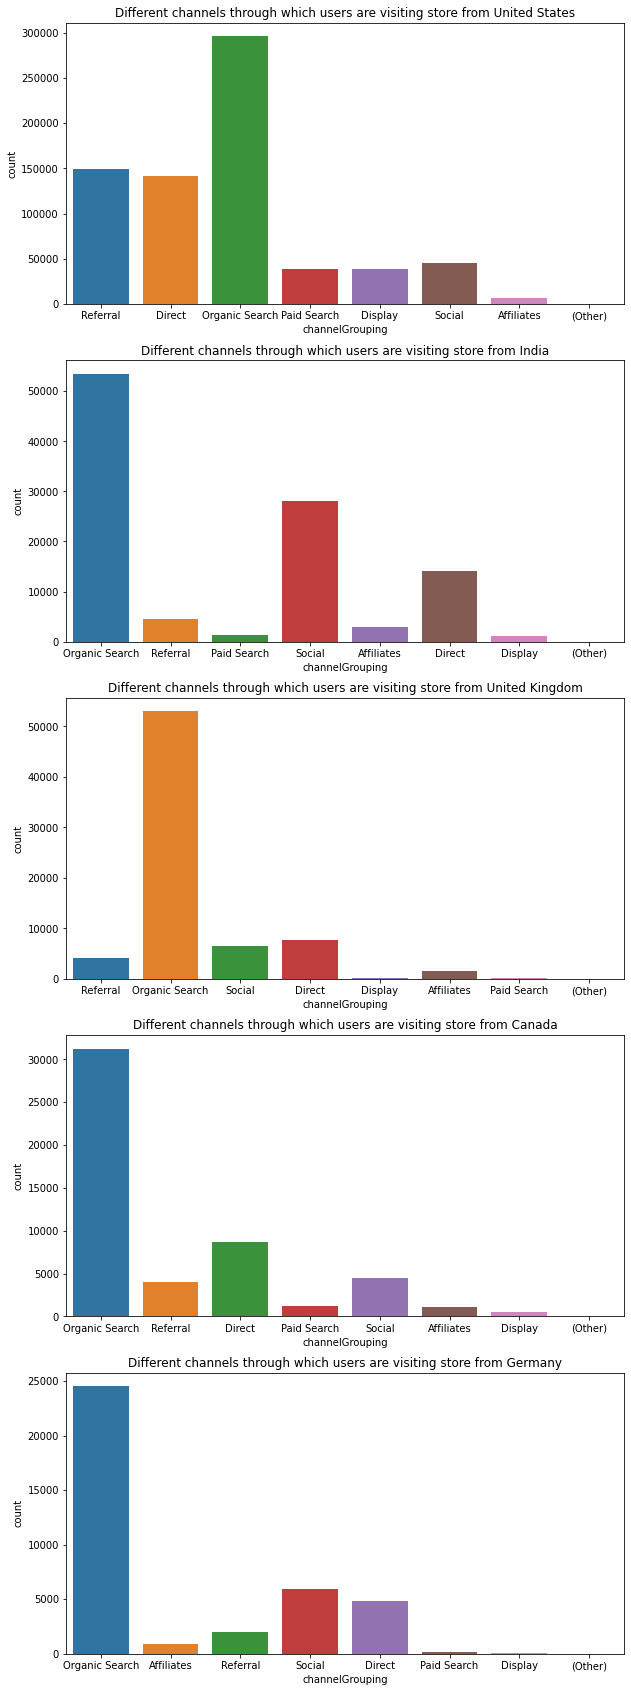

In [ ]:
plt.figure(figsize=(10,30))
plt.subplot(511)
sn.countplot(data_tr['channelGrouping'].loc[data_tr['country']=='United States'])
plt.title('Different channels through which users are visiting store from United States')
plt.subplot(512)
sn.countplot(data_tr['channelGrouping'].loc[data_tr['country']=='India'])
plt.title('Different channels through which users are visiting store from India')
plt.subplot(513)
sn.countplot(data_tr['channelGrouping'].loc[data_tr['country']=='United Kingdom'])
plt.title('Different channels through which users are visiting store from United Kingdom')
plt.subplot(514)
sn.countplot(data_tr['channelGrouping'].loc[data_tr['country']=='Canada'])
plt.title('Different channels through which users are visiting store from Canada')
plt.subplot(515)
sn.countplot(data_tr['channelGrouping'].loc[data_tr['country']=='Germany'])
plt.title('Different channels through which users are visiting store from Germany')
plt.show()

**Observations :**
There are noticable users that are visiting through Social channel group from India butas we know non zero transactions are negligible from India. Therefore, Marketing team should avoid investing in this channel group in India and can focus on United States instead as almost all non zero transactions taking place from there.

Lets also see amount of money spent per country.

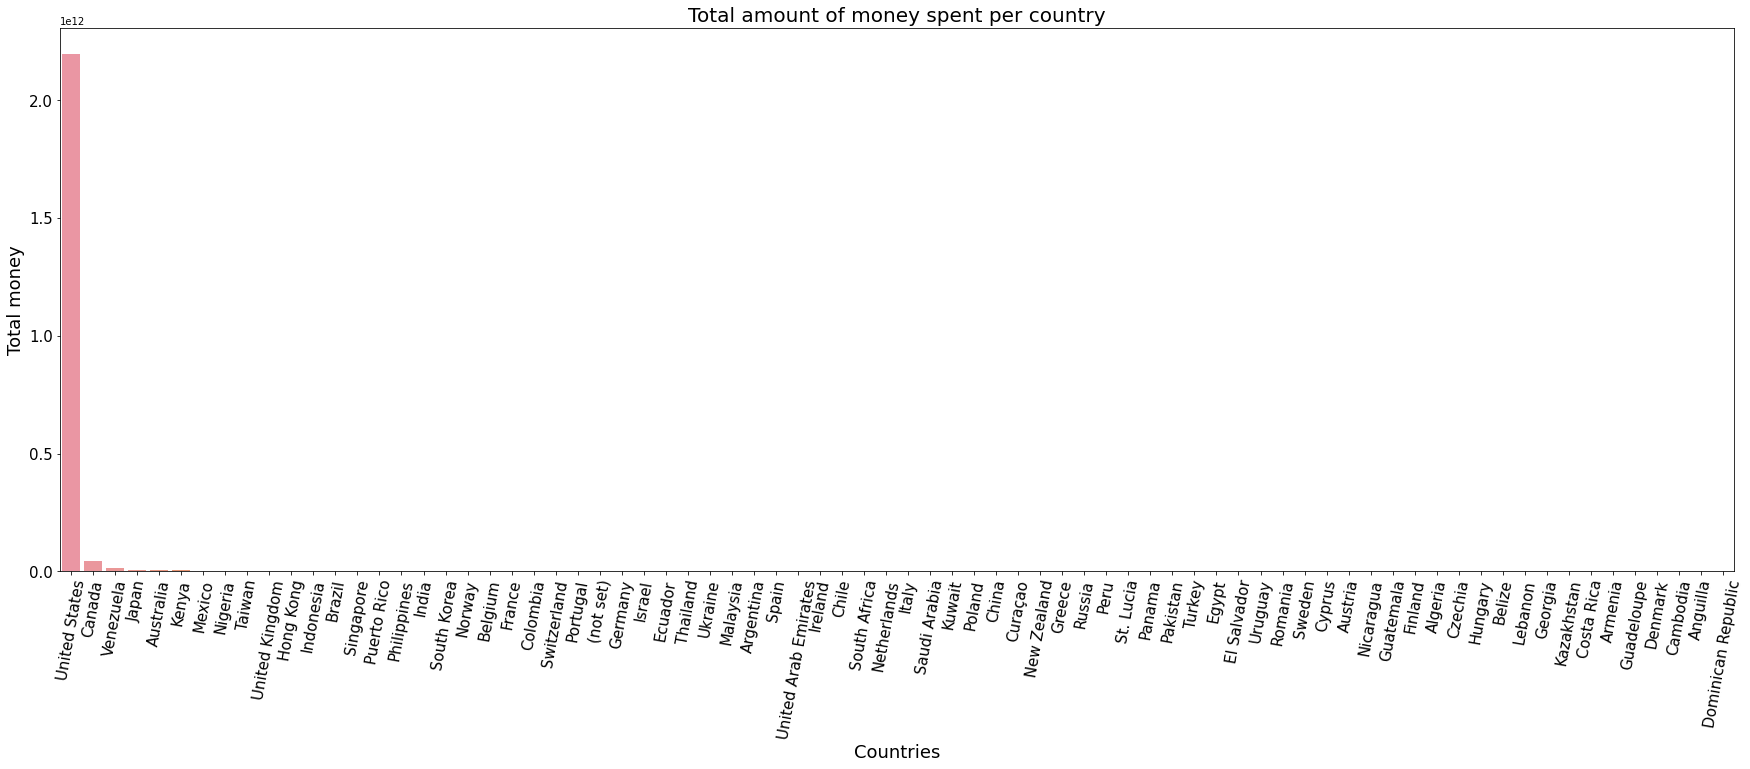

In [ ]:
amount_per_country=data_tr.groupby(['country'])['transactionRevenue'].sum().reset_index(name='sum_of_money').sort_values(['sum_of_money'], ascending=False)
non_zero_amounts=amount_per_country.loc[amount_per_country['sum_of_money']!=0]
plt.figure(figsize=(30,10))
sn.barplot(x=non_zero_amounts['country'],y=non_zero_amounts['sum_of_money'])
plt.title('Total amount of money spent per country',fontdict={'fontsize':20})
plt.xticks(fontsize=15,rotation=80)
plt.yticks(fontsize=15)
plt.xlabel('Countries',fontdict={'fontsize':18})
plt.ylabel('Total money',fontdict={'fontsize':18})
plt.show()

**Observation :**
1. From the above plot we can see users from United states spent the highest amount of money in the store.
2. All the other countries have spent nominal amount of money as compared to United States.

Text(0.5, 0, 'number of page views')

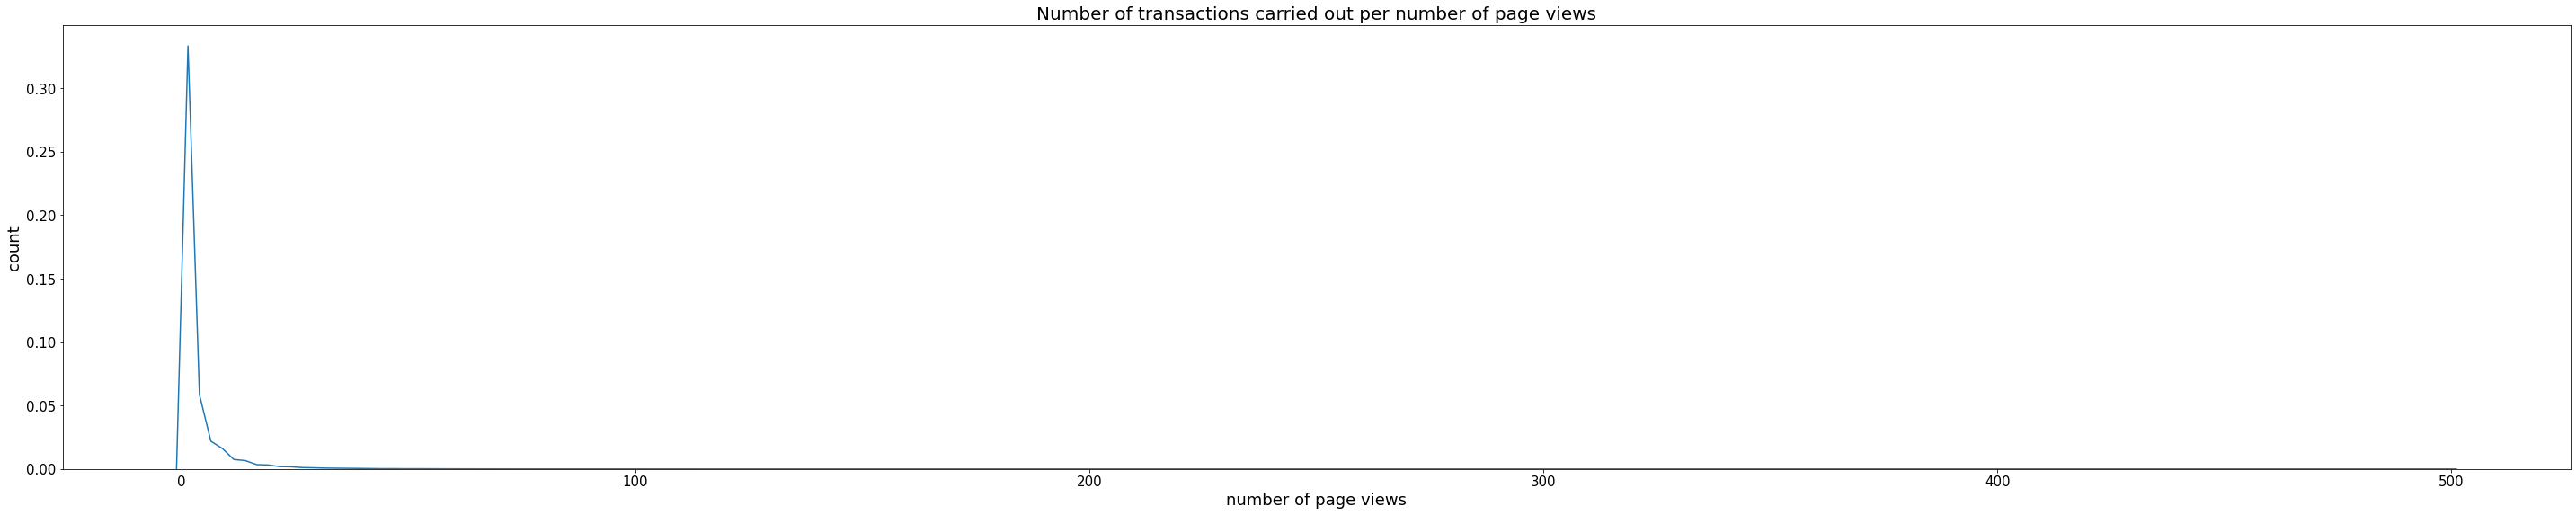

In [ ]:
plt.figure(figsize=(50,20))
plt.subplot(211)
sn.kdeplot(x=data_tr['pageviews'].values)
plt.title('Number of transactions carried out per number of page views',fontdict={'fontsize':20})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('count',fontdict={'fontsize':18})
plt.xlabel('number of page views',fontdict={'fontsize':18})

**Observations :**
1. It is also similar to plot of totals.timeonsite.
2. Plot for all transactions falling very sharply from start.
3. But in non zero transaction, first it is rising and then falling but not sharply.

Lets check distributions of some numerical features

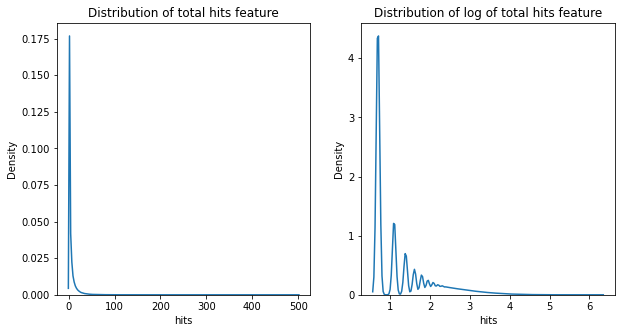

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sn.kdeplot(data_tr['hits'])
plt.title('Distribution of total hits feature')
plt.subplot(122)
sn.kdeplot(np.log1p(data_tr['hits']))
plt.title('Distribution of log of total hits feature')
plt.show()

We can see it follows pareto distribution. Therefore we should take the log of this feature.

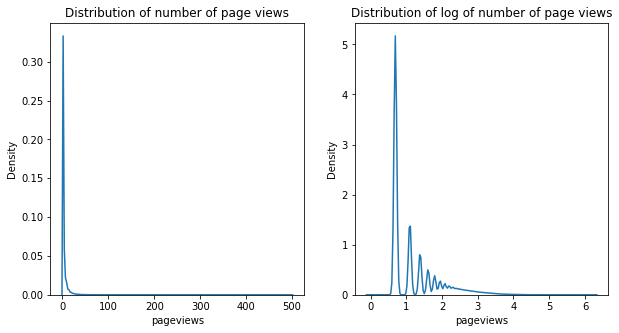

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sn.kdeplot(data_tr['pageviews'])
plt.title('Distribution of number of page views')
plt.subplot(122)
sn.kdeplot(np.log1p(data_tr['pageviews']))
plt.title('Distribution of log of number of page views')
plt.show()

We can see it also follows pareto distribution because many rows are having page views close to 0 and very less rows have greater number of page views. We should also take the log of this feature.

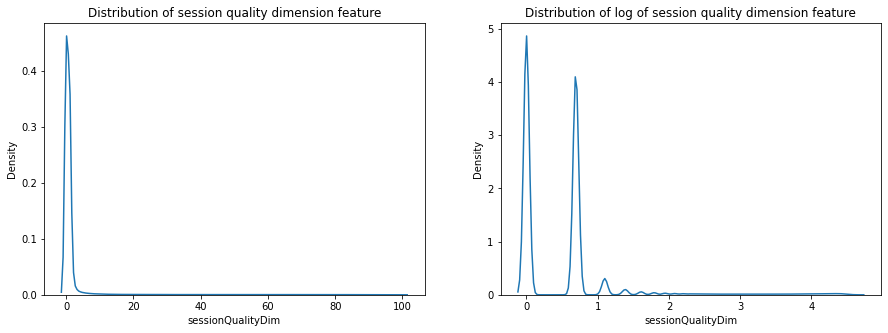

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sn.kdeplot(data_tr['sessionQualityDim'])
plt.title('Distribution of session quality dimension feature')
plt.subplot(122)
sn.kdeplot(np.log1p(data_tr['sessionQualityDim']))
plt.title('Distribution of log of session quality dimension feature')
plt.show()

It also follows pareto distribution. We will take log of this feature also.

In [ ]:
data_tr.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'visitNumber', 'visitStartTime', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'campaign', 'source',
       'medium', 'keyword', 'referralPath', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'hits', 'pageviews', 'sessionQualityDim',
       'timeOnSite', 'transactions', 'transactionRevenue'],
      dtype='object')

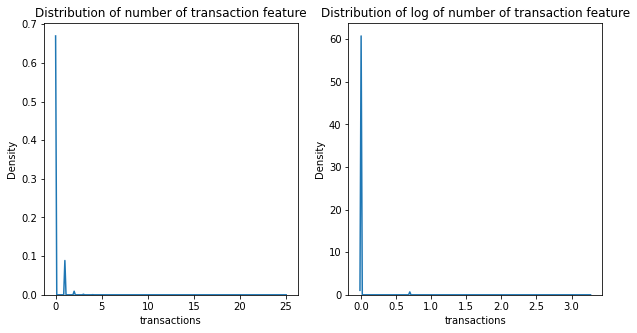

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sn.kdeplot(data_tr['transactions'])
plt.title('Distribution of number of transaction feature')
plt.subplot(122)
sn.kdeplot(np.log1p(data_tr['transactions']))
plt.title('Distribution of log of number of transaction feature')
plt.show()

Mostly it has value of 0 and close to 0. 

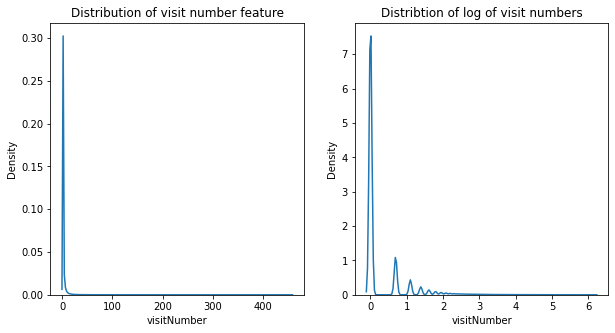

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sn.kdeplot(data_tr['visitNumber'])
plt.title('Distribution of visit number feature')
plt.subplot(122)
sn.kdeplot(np.log(data_tr['visitNumber']))
plt.title('Distribtion of log of visit numbers')
plt.show()

Almost every numerical feature here follows pareto distribution.

# **Feature Engineering**

In [ ]:
data_tr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/encoded_tr.csv',low_memory=False)
data_te=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/encoded_te.csv',low_memory=False)
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 28 columns):
 #   Column              Dtype  
---  ------              -----  
 0   channelGrouping     int64  
 1   customDimensions    int64  
 2   date                object 
 3   fullVisitorId       object 
 4   visitNumber         int64  
 5   visitStartTime      int64  
 6   continent           int64  
 7   subContinent        int64  
 8   country             int64  
 9   region              int64  
 10  metro               int64  
 11  city                int64  
 12  networkDomain       int64  
 13  campaign            int64  
 14  source              int64  
 15  medium              int64  
 16  keyword             int64  
 17  referralPath        int64  
 18  browser             int64  
 19  operatingSystem     int64  
 20  isMobile            int64  
 21  deviceCategory      int64  
 22  hits                int64  
 23  pageviews           float64
 24  sessionQualityDim   floa

In [ ]:
data_tr['date']=pd.to_datetime(data_tr['date'])
data_te['date']=pd.to_datetime(data_te['date'])

In [ ]:
from datetime import timedelta

In [ ]:
data_tr.shape

(1708337, 28)

In [ ]:
def get_time_series_features(data,k):
    
    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) 
                           & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]
    
    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
      #in code k=1 and min(data['date']) = aug 1st 2016
       # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)
    
    
    
    
    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) 
                    & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]
    
    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
      #in code max(train_frame_k['date'])=jan 15th 2017
       # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"
    
    

    
    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection
    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction
    
    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period. 
    # Here cooling period means(=46 days) from "train_frame" end date
    #so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.
    
    
    
    # preparing returned customers data:
    # ----------------------------------
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]  
    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    returned_customers_transactions['is_returned'] = 1
    returned_customers_transactions.rename(columns={'transactionRevenue': 'revenue'}, inplace=True) 
    
    
    
    
    # preparing non-returned customers data:
    # ----------------------------------
    
    non_returned_customers_data                  = pd.DataFrame()
    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))
    non_returned_customers_data['is_returned']   = 0
    non_returned_customers_data['revenue']       = 0
    
    
    # so final time based featurizations(for classification model):
    #--------------------------------------------------------------------
    # we are concatinating returned and non-returned users 
    
    classification_features = pd.concat([returned_customers_transactions, non_returned_customers_data], axis=0)\
                              .reset_index(drop=True)
    
    
   
    
    # featurization for train_frame_k data :
    # ------------------------------------------
    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation
    
    train_frame_k_maxdate = max(train_frame_k['date'])
    train_frame_k_mindate = min(train_frame_k['date'])
    
    train_frame_k = train_frame_k.groupby('fullVisitorId').agg({
            'networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'customDimensions': [('customDimensions' , lambda x: x.dropna().max())],
            'city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
            'referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
            'transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - train_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    train_frame_k.columns = train_frame_k.columns.droplevel() 
    
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_frame_k = pd.merge(train_frame_k, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_frame_k

In [ ]:
data=pd.concat([data_tr.reset_index(drop=True),data_te.reset_index(drop=True)],axis=0)
print(data.shape)

(2109926, 28)


In [ ]:
train_frame_1 = get_time_series_features(data,1)
print(train_frame_1.shape)
train_frame_1.head()

(379029, 40)


,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000093957001069502,0,4,1096,22,129,517,4,1,219,...,0.0,0,1,0.0,57 days,110 days,0 days,1,0.0,0
1,0000168159078983594,18403,1,1096,22,129,517,4,1,202,...,0.0,0,1,0.0,54 days,113 days,0 days,1,0.0,0
2,0000174067426171406,44691,4,1096,25,129,517,4,1,36,...,0.0,1,1,0.0,101 days,66 days,0 days,1,0.0,0
3,0000245437374675368,34589,4,1096,22,129,517,7,3084,219,...,0.0,0,1,0.0,32 days,135 days,0 days,1,0.0,0
4,0000253133284033056,31435,0,1,0,0,0,7,3105,195,...,0.0,1,1,0.0,8 days,159 days,0 days,1,0.0,0


In [ ]:
train_frame_1.to_pickle('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_1.pkl',index=False)

In [ ]:
train_frame_2 = get_time_series_features(data,2)
print(train_frame_2.shape)
train_frame_2.head()

(290508, 40)


,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000068403966359845,1232,4,536,25,64,74,4,1,219,...,0.0,1,1,0.0,77 days,90 days,0 days,1,0.0,0
1,0000197671390269035,0,4,1096,1,129,517,7,1,219,...,0.0,1,1,0.0,106 days,61 days,0 days,1,0.0,0
2,000026722803385797,44691,3,1096,7,129,517,4,1,218,...,0.0,0,1,0.0,140 days,27 days,0 days,1,0.0,0
3,0000650183049109374,0,1,209,1,0,453,4,1,93,...,0.0,1,1,0.0,136 days,31 days,0 days,1,0.0,0
4,0000702913088027926,10271,0,1096,25,129,517,4,1,157,...,0.0,1,6,0.0,65 days,102 days,0 days,1,0.0,0


In [ ]:
train_frame_2.to_pickle('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_2.pkl')

In [ ]:
train_frame_3 = get_time_series_features(data,3)
print(train_frame_3.shape)
train_frame_3.head()

(387681, 40)


,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000000259678714014,44691,4,621,7,104,74,4,1,219,...,11.0,0,2,0.0,148 days,19 days,0 days,1,0.0,0
1,0000049363351866189,0,1,1096,3,129,517,2,1,93,...,1.0,0,3,0.0,77 days,89 days,1 days,2,0.0,0
2,0000085840370633780,0,4,858,7,104,74,4,1,219,...,1.0,0,1,0.0,67 days,100 days,0 days,1,0.0,0
3,0000117255350596610,36940,4,1096,22,129,517,2,1,219,...,63.0,0,1,0.0,128 days,39 days,0 days,1,0.0,0
4,0000118334805178127,0,4,1096,1,129,517,3,1,219,...,1.0,1,1,0.0,95 days,72 days,0 days,1,0.0,0


In [ ]:
train_frame_3.to_pickle('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_3.pkl')

In [ ]:
train_frame_3.columns

Index(['fullVisitorId', 'networkDomain', 'customDimensions', 'city',
       'operatingSystem', 'metro', 'region', 'channelGrouping', 'referralPath',
       'country', 'source', 'medium', 'keyword', 'browser', 'deviceCategory',
       'continent', 'subcontinent', 'timeOnSite_sum', 'timeOnSite_min',
       'timeOnSite_max', 'timeOnSite_mean', 'pageviews_sum', 'pageviews_min',
       'pageviews_max', 'pageviews_mean', 'hits_sum', 'hits_min', 'hits_max',
       'hits_mean', 'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num',
       'revenue', 'is_returned'],
      dtype='object')

In [ ]:
train_frame_4 = get_time_series_features(data,4)
print(train_frame_4.shape)
train_frame_4.head()

(368143, 40)


,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000053049821714864,33653,5,1096,25,129,517,1,1,9,...,1.0,1,1,0.0,41 days,126 days,0 days,1,0.0,0
1,0000059488412965267,0,4,212,1,21,205,2,1,219,...,1.0,1,1,0.0,65 days,102 days,0 days,1,0.0,0
2,0000073585230191399,0,4,1096,25,129,517,4,0,219,...,1.0,1,1,0.0,167 days,0 days,0 days,1,0.0,0
3,0000149787903119437,41526,0,1096,1,129,517,4,0,174,...,1.0,1,1,0.0,154 days,13 days,0 days,1,0.0,0
4,0000150005271820273,19606,3,292,22,0,111,4,1,97,...,1.0,0,1,0.0,38 days,129 days,0 days,1,0.0,0


In [ ]:
train_frame_4.to_pickle('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_4.pkl')

In [ ]:
def get_time_series_features_for_test(test_data):
    
    
    test_frame_k_maxdate = max(test_data['date'])
    test_frame_k_mindate = min(test_data['date'])
    
    test_frame_k = test_data.groupby('fullVisitorId').agg({
            'networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'customDimensions': [('customDimensions' , lambda x: x.dropna().max())],
            'city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
            'referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
            'transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - test_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: test_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    test_frame_k.columns = test_frame_k.columns.droplevel() 
    
    return test_frame_k

In [ ]:
test_frame_5 = get_time_series_features_for_test(data_te)
print(test_frame_5.shape)
test_frame_5.head()

(296530, 37)


,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,hits_mean,visitStartTime_counts,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000018966949534117,0,4,861,7,104,74,4,0,219,117,...,7.0,1,1,0,1,0.0,104 days,63 days,0 days,1
0000039738481224681,0,4,1096,1,129,517,2,0,219,0,...,1.0,1,1,1,1,0.0,43 days,124 days,0 days,1
0000073585230191399,0,4,1096,25,129,517,4,0,219,117,...,1.0,1,1,1,1,0.0,33 days,134 days,0 days,1
0000087588448856385,42363,1,1096,22,129,517,4,0,202,117,...,1.0,1,1,0,1,0.0,36 days,131 days,0 days,1
0000149787903119437,41526,0,1096,1,129,517,4,0,174,117,...,1.0,1,1,1,1,0.0,20 days,147 days,0 days,1


In [ ]:
test_frame_5['revenue']     = np.nan
test_frame_5['is_returned'] = np.nan

In [ ]:
test_frame_5['fullVisitorId']=test_frame_5.index

In [ ]:
test_frame_5.reset_index(drop=True,inplace=True)
test_frame_5.head()

,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned,fullVisitorId
0,0,4,861,7,104,74,4,0,219,117,...,0,1,0.0,104 days,63 days,0 days,1,NaN,NaN,0000018966949534117
1,0,4,1096,1,129,517,2,0,219,0,...,1,1,0.0,43 days,124 days,0 days,1,NaN,NaN,0000039738481224681
2,0,4,1096,25,129,517,4,0,219,117,...,1,1,0.0,33 days,134 days,0 days,1,NaN,NaN,0000073585230191399
3,42363,1,1096,22,129,517,4,0,202,117,...,0,1,0.0,36 days,131 days,0 days,1,NaN,NaN,0000087588448856385
4,41526,0,1096,1,129,517,4,0,174,117,...,1,1,0.0,20 days,147 days,0 days,1,NaN,NaN,0000149787903119437


In [ ]:
test_frame_5=test_frame_5[train_frame_4.columns]
test_frame_5.head()

,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000018966949534117,0,4,861,7,104,74,4,0,219,...,1,0,1,0.0,104 days,63 days,0 days,1,NaN,NaN
1,0000039738481224681,0,4,1096,1,129,517,2,0,219,...,1,1,1,0.0,43 days,124 days,0 days,1,NaN,NaN
2,0000073585230191399,0,4,1096,25,129,517,4,0,219,...,1,1,1,0.0,33 days,134 days,0 days,1,NaN,NaN
3,0000087588448856385,42363,1,1096,22,129,517,4,0,202,...,1,0,1,0.0,36 days,131 days,0 days,1,NaN,NaN
4,0000149787903119437,41526,0,1096,1,129,517,4,0,174,...,1,1,1,0.0,20 days,147 days,0 days,1,NaN,NaN


In [ ]:
test_frame_5.to_pickle('/content/drive/MyDrive/Colab Notebooks/self case study 1/test_frame_5.pkl')

In [ ]:
tr1=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_1.pkl')
tr2=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_2.pkl')
tr3=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_3.pkl')
tr4=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/self case study 1/train_frame_4.pkl')
tr5=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/self case study 1/test_frame_5.pkl')

In [ ]:
final_featurized_data = pd.concat([tr1.reset_index(drop=True), tr2.reset_index(drop=True), tr3.reset_index(drop=True), tr4.reset_index(drop=True), tr5.reset_index(drop=True)], axis=0, sort=False)

In [ ]:
final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

In [ ]:
final_featurized_data.head()

,fullVisitorId,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000093957001069502,0,4,1096,22,129,517,4,1,219,...,0.0,0,1,0.0,57,110,0,1,0.0,0.0
1,0000168159078983594,18403,1,1096,22,129,517,4,1,202,...,0.0,0,1,0.0,54,113,0,1,0.0,0.0
2,0000174067426171406,44691,4,1096,25,129,517,4,1,36,...,0.0,1,1,0.0,101,66,0,1,0.0,0.0
3,0000245437374675368,34589,4,1096,22,129,517,7,3084,219,...,0.0,0,1,0.0,32,135,0,1,0.0,0.0
4,0000253133284033056,31435,0,1,0,0,0,7,3105,195,...,0.0,1,1,0.0,8,159,0,1,0.0,0.0


In [ ]:
train_df = final_featurized_data[final_featurized_data['revenue'].notnull()]
test_df  = final_featurized_data[final_featurized_data['revenue'].isnull()]

In [ ]:
print(train_df.shape,test_df.shape)

(1425361, 40) (296530, 40)


In [ ]:
final_featurized_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721891 entries, 0 to 296529
Data columns (total 40 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   fullVisitorId                    object 
 1   networkDomain                    int64  
 2   customDimensions                 int64  
 3   city                             int64  
 4   operatingSystem                  int64  
 5   metro                            int64  
 6   region                           int64  
 7   channelGrouping                  int64  
 8   referralPath                     int64  
 9   country                          int64  
 10  source                           int64  
 11  medium                           int64  
 12  keyword                          int64  
 13  browser                          int64  
 14  deviceCategory                   int64  
 15  continent                        int64  
 16  subcontinent                     int64  
 17  timeOnSit

In [ ]:
# train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_with_tbf.csv',index=False)
# test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/test_with_tbf.csv',index=False)

In [ ]:
data_tr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/train_with_tbf.csv',low_memory=False)
data_te=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/test_with_tbf.csv',low_memory=False)

# **Feature Selection**

In [ ]:
data_tr.columns

Index(['fullVisitorId', 'networkDomain', 'customDimensions', 'city',
       'operatingSystem', 'metro', 'region', 'channelGrouping', 'referralPath',
       'country', 'source', 'medium', 'keyword', 'browser', 'deviceCategory',
       'continent', 'subcontinent', 'timeOnSite_sum', 'timeOnSite_min',
       'timeOnSite_max', 'timeOnSite_mean', 'pageviews_sum', 'pageviews_min',
       'pageviews_max', 'pageviews_mean', 'hits_sum', 'hits_min', 'hits_max',
       'hits_mean', 'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num',
       'revenue', 'is_returned'],
      dtype='object')

Checking multicollinearity using VARIANCE INFLATION FACTOR

In [ ]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425361 entries, 0 to 1425360
Data columns (total 40 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   fullVisitorId                    1425361 non-null  object 
 1   networkDomain                    1425361 non-null  int64  
 2   customDimensions                 1425361 non-null  int64  
 3   city                             1425361 non-null  int64  
 4   operatingSystem                  1425361 non-null  int64  
 5   metro                            1425361 non-null  int64  
 6   region                           1425361 non-null  int64  
 7   channelGrouping                  1425361 non-null  int64  
 8   referralPath                     1425361 non-null  int64  
 9   country                          1425361 non-null  int64  
 10  source                           1425361 non-null  int64  
 11  medium                           1425361 non-null 

In [ ]:
#dropping unuseful features
data=data_tr.drop(columns=['fullVisitorId','revenue','is_returned'])
data.head()

,networkDomain,customDimensions,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,hits_mean,visitStartTime_counts,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num
0,0,4,1096,22,129,517,4,1,219,0,...,2.0,1,0.0,0,1,0.0,57,110,0,1
1,18403,1,1096,22,129,517,4,1,202,0,...,76.0,1,0.0,0,1,0.0,54,113,0,1
2,44691,4,1096,25,129,517,4,1,36,0,...,28.0,1,0.0,1,1,0.0,101,66,0,1
3,34589,4,1096,22,129,517,7,3084,219,386,...,2.0,1,0.0,0,1,0.0,32,135,0,1
4,31435,0,1,0,0,0,7,3105,195,386,...,1.0,1,0.0,1,1,0.0,8,159,0,1


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features          VIF
0                     networkDomain     1.149318
1                  customDimensions     1.503944
2                              city     4.203876
3                   operatingSystem     1.185658
4                             metro     3.889790
5                            region     2.339041
6                   channelGrouping     3.256264
7                      referralPath     5.264524
8                           country     1.321563
9                            source     8.896569
10                           medium     3.188771
11                          keyword     1.012191
12                          browser     1.220314
13                   deviceCategory     9.143498
14                        continent     1.344282
15                     subcontinent     1.075765
16                   timeOnSite_sum    11.916058
17                   timeOnSite_min    32.449971
18                   timeOnSite_max    33.048955
19                  

Deleting the feature that has highest VIF and that is **pageviews_mean** and then we will again check VIF.

In [ ]:
data.drop(columns='pageviews_mean',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features         VIF
0                     networkDomain    1.149311
1                  customDimensions    1.503908
2                              city    4.203873
3                   operatingSystem    1.185641
4                             metro    3.889686
5                            region    2.338937
6                   channelGrouping    3.254867
7                      referralPath    5.264354
8                           country    1.321555
9                            source    8.896064
10                           medium    3.188730
11                          keyword    1.012190
12                          browser    1.220313
13                   deviceCategory    9.143489
14                        continent    1.344258
15                     subcontinent    1.075756
16                   timeOnSite_sum   11.916041
17                   timeOnSite_min   31.237226
18                   timeOnSite_max   32.391245
19                  timeOnSite_mean   82

Next we are deleting another feature that has highest VIF and that is **pageviews_sum**

In [ ]:
data.drop(columns='pageviews_sum',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features        VIF
0                     networkDomain   1.149300
1                  customDimensions   1.503908
2                              city   4.203863
3                   operatingSystem   1.185637
4                             metro   3.889685
5                            region   2.338843
6                   channelGrouping   3.254662
7                      referralPath   5.264351
8                           country   1.321553
9                            source   8.896014
10                           medium   3.188730
11                          keyword   1.012188
12                          browser   1.220312
13                   deviceCategory   9.143485
14                        continent   1.344242
15                     subcontinent   1.075756
16                   timeOnSite_sum  10.788522
17                   timeOnSite_min  31.237122
18                   timeOnSite_max  31.654044
19                  timeOnSite_mean  82.102369
20           

Next we are deleting **hits_mean**.

In [ ]:
data.drop(columns='hits_mean',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features        VIF
0                     networkDomain   1.149297
1                  customDimensions   1.503886
2                              city   4.203825
3                   operatingSystem   1.185592
4                             metro   3.889567
5                            region   2.338843
6                   channelGrouping   3.253072
7                      referralPath   5.263746
8                           country   1.321532
9                            source   8.895945
10                           medium   3.188421
11                          keyword   1.012186
12                          browser   1.220312
13                   deviceCategory   9.143461
14                        continent   1.344214
15                     subcontinent   1.075747
16                   timeOnSite_sum  10.751281
17                   timeOnSite_min  22.708669
18                   timeOnSite_max  26.570799
19                  timeOnSite_mean  58.158499
20           

Next we are deleting **hits_max**

In [ ]:
data.drop(columns='hits_max',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features        VIF
0                     networkDomain   1.149294
1                  customDimensions   1.503847
2                              city   4.203788
3                   operatingSystem   1.185587
4                             metro   3.889544
5                            region   2.338658
6                   channelGrouping   3.252756
7                      referralPath   5.263741
8                           country   1.321519
9                            source   8.895052
10                           medium   3.188215
11                          keyword   1.012186
12                          browser   1.220309
13                   deviceCategory   9.143456
14                        continent   1.344185
15                     subcontinent   1.075742
16                   timeOnSite_sum   9.990344
17                   timeOnSite_min  22.708468
18                   timeOnSite_max  26.378531
19                  timeOnSite_mean  58.152946
20           

Next we are deleting **timeOnSite_mean**

In [ ]:
data.drop(columns='timeOnSite_mean',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features        VIF
0                     networkDomain   1.149291
1                  customDimensions   1.503836
2                              city   4.203708
3                   operatingSystem   1.185572
4                             metro   3.889382
5                            region   2.338648
6                   channelGrouping   3.251739
7                      referralPath   5.263385
8                           country   1.321467
9                            source   8.893657
10                           medium   3.188209
11                          keyword   1.012185
12                          browser   1.220212
13                   deviceCategory   9.143420
14                        continent   1.344115
15                     subcontinent   1.075736
16                   timeOnSite_sum   9.950324
17                   timeOnSite_min   3.497616
18                   timeOnSite_max   9.745272
19                    pageviews_min  29.339997
20           

deleting **pageviews_min**.

In [ ]:
data.drop(columns='pageviews_min',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                           features        VIF
0                     networkDomain   1.149141
1                  customDimensions   1.503005
2                              city   4.203649
3                   operatingSystem   1.185550
4                             metro   3.889110
5                            region   2.338409
6                   channelGrouping   3.249119
7                      referralPath   5.262811
8                           country   1.321257
9                            source   8.888237
10                           medium   3.188192
11                          keyword   1.012154
12                          browser   1.220166
13                   deviceCategory   9.142640
14                        continent   1.343888
15                     subcontinent   1.075619
16                   timeOnSite_sum   9.311696
17                   timeOnSite_min   3.111840
18                   timeOnSite_max   8.850975
19                    pageviews_max   9.950742
20           

deleting **first_ses_from_the_period_startchannelGrouping**

In [ ]:
data.drop(columns='first_ses_from_the_period_start',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.733218
1               customDimensions   4.689779
2                           city  28.018070
3                operatingSystem   3.727054
4                          metro  14.123858
5                         region  12.399757
6                channelGrouping  20.930355
7                   referralPath   6.869356
8                        country   7.023199
9                         source  17.557136
10                        medium  10.286817
11                       keyword   1.027256
12                       browser  13.483158
13                deviceCategory  12.891880
14                     continent  11.440095
15                  subcontinent   8.778975
16                timeOnSite_sum   9.959698
17                timeOnSite_min   3.441993
18                timeOnSite_max   9.980944
19                 pageviews_max  13.112330
20                      hits_sum  12.018163
21                      hits_min

deleting **city**

In [ ]:
data.drop(columns='city',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.713460
1               customDimensions   4.646918
2                operatingSystem   3.722790
3                          metro   7.458216
4                         region  10.504516
5                channelGrouping  20.744198
6                   referralPath   6.864293
7                        country   6.941853
8                         source  17.544523
9                         medium  10.283047
10                       keyword   1.027245
11                       browser  13.406572
12                deviceCategory  12.891140
13                     continent  11.119702
14                  subcontinent   8.776093
15                timeOnSite_sum   9.959409
16                timeOnSite_min   3.441912
17                timeOnSite_max   9.980705
18                 pageviews_max  13.109193
19                      hits_sum  12.014678
20                      hits_min   4.180251
21         visitStartTime_counts

deleting **unqiue_date_num**

In [ ]:
data.drop(columns='unqiue_date_num',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.710693
1               customDimensions   4.639794
2                operatingSystem   3.722711
3                          metro   7.457225
4                         region  10.490088
5                channelGrouping  20.649282
6                   referralPath   6.862011
7                        country   6.909706
8                         source  17.544509
9                         medium  10.277140
10                       keyword   1.027223
11                       browser  13.348145
12                deviceCategory  12.890732
13                     continent  11.032774
14                  subcontinent   8.746836
15                timeOnSite_sum   9.645038
16                timeOnSite_min   3.423471
17                timeOnSite_max   9.940978
18                 pageviews_max  13.069008
19                      hits_sum  11.915790
20                      hits_min   4.180246
21         visitStartTime_counts

deleting **channelGrouping**

In [ ]:
data.drop(columns='channelGrouping',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.710691
1               customDimensions   4.530703
2                operatingSystem   3.721303
3                          metro   7.418788
4                         region  10.488073
5                   referralPath   6.369969
6                        country   6.648714
7                         source  16.750800
8                         medium   9.929578
9                        keyword   1.026910
10                       browser  13.084880
11                deviceCategory  12.881941
12                     continent  10.426963
13                  subcontinent   8.590692
14                timeOnSite_sum   9.642791
15                timeOnSite_min   3.423377
16                timeOnSite_max   9.940953
17                 pageviews_max  12.996231
18                      hits_sum  11.893879
19                      hits_min   4.180137
20         visitStartTime_counts   6.454280
21             sessionQualityDim

deleting **source**

In [ ]:
data.drop(columns='source',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.710691
1               customDimensions   4.510632
2                operatingSystem   3.717892
3                          metro   7.411895
4                         region  10.488073
5                   referralPath   2.015398
6                        country   6.648296
7                         medium   4.518110
8                        keyword   1.026796
9                        browser  13.066269
10                deviceCategory  12.881797
11                     continent  10.360182
12                  subcontinent   8.582420
13                timeOnSite_sum   9.642782
14                timeOnSite_min   3.423369
15                timeOnSite_max   9.938766
16                 pageviews_max  12.995475
17                      hits_sum  11.892579
18                      hits_min   4.180092
19         visitStartTime_counts   6.453468
20             sessionQualityDim   1.397600
21                      isMobile

deleting **isMobile**

In [ ]:
data.drop(columns='isMobile',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.709451
1               customDimensions   4.509957
2                operatingSystem   3.568871
3                          metro   7.406453
4                         region  10.482210
5                   referralPath   2.000258
6                        country   6.645752
7                         medium   4.513557
8                        keyword   1.026615
9                        browser  12.869337
10                deviceCategory   1.748142
11                     continent  10.354833
12                  subcontinent   8.558438
13                timeOnSite_sum   9.642534
14                timeOnSite_min   3.423356
15                timeOnSite_max   9.938739
16                 pageviews_max  12.995395
17                      hits_sum  11.892486
18                      hits_min   4.180067
19         visitStartTime_counts   6.447953
20             sessionQualityDim   1.397031
21               visitNumber_max

deleting **pageviews_max**

In [ ]:
data.drop(columns='pageviews_max',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.709451
1               customDimensions   4.501147
2                operatingSystem   3.568862
3                          metro   7.404130
4                         region  10.482055
5                   referralPath   1.998944
6                        country   6.629193
7                         medium   4.513555
8                        keyword   1.026598
9                        browser  12.860960
10                deviceCategory   1.748104
11                     continent  10.345089
12                  subcontinent   8.556706
13                timeOnSite_sum   7.312737
14                timeOnSite_min   3.262773
15                timeOnSite_max   6.310536
16                      hits_sum   5.187737
17                      hits_min   3.084839
18         visitStartTime_counts   6.330522
19             sessionQualityDim   1.388404
20               visitNumber_max   3.203314
21                  transactions

deleting **browser**

In [ ]:
data.drop(columns='browser',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features        VIF
0                  networkDomain   2.697691
1               customDimensions   4.430074
2                operatingSystem   3.325089
3                          metro   7.403171
4                         region  10.412213
5                   referralPath   1.952502
6                        country   6.214051
7                         medium   4.502298
8                        keyword   1.024922
9                 deviceCategory   1.491262
10                     continent   9.719643
11                  subcontinent   8.376051
12                timeOnSite_sum   7.310911
13                timeOnSite_min   3.262625
14                timeOnSite_max   6.310418
15                      hits_sum   5.187066
16                      hits_min   3.083732
17         visitStartTime_counts   6.313946
18             sessionQualityDim   1.388178
19               visitNumber_max   3.203077
20                  transactions   1.378096
21  last_ses_from_the_period_end

deleting **region**

In [ ]:
data.drop(columns='region',inplace=True)
vif_df=pd.DataFrame()
vif_df["features"] = data.columns
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
print(vif_df)

                        features       VIF
0                  networkDomain  2.651965
1               customDimensions  4.429955
2                operatingSystem  3.280401
3                          metro  3.845144
4                   referralPath  1.951012
5                        country  6.095233
6                         medium  4.443425
7                        keyword  1.024898
8                 deviceCategory  1.474898
9                      continent  9.170451
10                  subcontinent  8.353930
11                timeOnSite_sum  7.310848
12                timeOnSite_min  3.262590
13                timeOnSite_max  6.310040
14                      hits_sum  5.186396
15                      hits_min  3.082489
16         visitStartTime_counts  6.303352
17             sessionQualityDim  1.386906
18               visitNumber_max  3.201930
19                  transactions  1.377861
20  last_ses_from_the_period_end  3.779280
21                interval_dates  1.490064


Now we have all the non multicollinear features. Lets drop these features from original dataset also.

In [ ]:
set(data_tr.columns)-set(data.columns)

{'browser',
 'channelGrouping',
 'city',
 'first_ses_from_the_period_start',
 'fullVisitorId',
 'hits_max',
 'hits_mean',
 'isMobile',
 'is_returned',
 'pageviews_max',
 'pageviews_mean',
 'pageviews_min',
 'pageviews_sum',
 'region',
 'revenue',
 'source',
 'timeOnSite_mean',
 'unqiue_date_num'}

In [ ]:
cols_to_del=['browser',
 'channelGrouping',
 'city',
 'first_ses_from_the_period_start',
 'hits_max',
 'hits_mean',
 'isMobile',
 'pageviews_max',
 'pageviews_mean',
 'pageviews_min',
 'pageviews_sum',
 'region',
 'source',
 'timeOnSite_mean',
 'unqiue_date_num']

In [ ]:
data_tr.drop(columns=cols_to_del,inplace=True)
data_te.drop(columns=cols_to_del,inplace=True)
print(data_tr.shape,data_te.shape)

(1425361, 25) (296530, 25)


In [ ]:
data_tr.columns

Index(['fullVisitorId', 'networkDomain', 'customDimensions', 'operatingSystem',
       'metro', 'referralPath', 'country', 'medium', 'keyword',
       'deviceCategory', 'continent', 'subcontinent', 'timeOnSite_sum',
       'timeOnSite_min', 'timeOnSite_max', 'hits_sum', 'hits_min',
       'visitStartTime_counts', 'sessionQualityDim', 'visitNumber_max',
       'transactions', 'last_ses_from_the_period_end', 'interval_dates',
       'revenue', 'is_returned'],
      dtype='object')

In [ ]:
data_tr.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_data_tr_tbf_without_corr.csv',index=False)
data_te.to_csv('/content/drive/MyDrive/Colab Notebooks/self case study 1/full_data_te_tbf_without_corr.csv',index=False)